In [3]:
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [4]:
import sys
import pandas as pd
import numpy as np

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features, scatterplot_regression_predictions, plot_roc, plot_prc
from stabl.utils import nonpartition_cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split


from sklearn.linear_model import Lasso, LogisticRegression

%config InlineBackend.figure_formats=['retina'] 

# Models

We define here the sparse models that will be used in the bootstrap process of Stabl:
* In the regression case, we use the classic Lasso,
* In the binary classification case, we use the Logistic Regression with l1 penalization

In [5]:
lasso = Lasso(max_iter=int(1e6))
logit_lasso = LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced")

# Data

## Regression case

For the regression case, we will use the Onset of Labor use case:
* CyTOF layer
* Proteomics layer
* Metabolomics layer

The outcome is the onset of labor (in days before labor)

In [6]:
prot_ool = pd.read_csv("../Sample Data/Onset of Labor/Training/Proteomics.csv", index_col=0)
meta_ool = pd.read_csv("../Sample Data/Onset of Labor/Training/Metabolomics.csv", index_col=0)
cyto_ool = pd.read_csv("../Sample Data/Onset of Labor/Training/CyTOF.csv", index_col=0)

DOS_ool = pd.read_csv("../Sample Data/Onset of Labor/Training/DOS.csv", index_col=0).DOS

In [7]:
prot_ool.shape
prot_ool


,CHIP,CEBPB,NSE,PIAS4,IL.10.Ra,STAT3,IRF1,c.Jun,Mcl.1,OAS1,...,UB2G2,Transgelin.2,ATPO,Corticotropin.lipotropin,QORL1,PEDF,CATF,FTCD,UBP25,PLXB2
ID,,,,,,,,,,,,,,,,,,,,,
001_26_A,8.745170,8.330021,11.124444,8.930146,9.028182,8.512148,10.476847,10.314810,9.078151,7.386294,...,12.267138,10.440558,8.771159,7.355792,10.584305,14.974755,10.774787,12.570093,9.059344,11.412305
001_33_B,8.591709,9.392961,13.511889,9.157347,9.878817,8.521208,9.960871,9.951285,8.915581,7.080018,...,12.349060,10.765535,8.440039,9.020424,11.343963,15.142498,11.283899,10.902978,9.171677,12.306460
001_35_C,8.279378,9.476341,13.108688,9.284246,9.999577,8.198199,10.074677,9.960292,8.845490,7.291861,...,12.443021,10.509478,8.529821,8.449149,11.391727,15.018600,11.254438,10.901772,9.149239,12.532843
003_25_A,8.659639,9.275193,13.349945,8.980425,10.276822,8.656067,9.704595,10.187971,8.704595,7.686501,...,12.774808,10.978639,9.123345,8.294621,11.180717,14.704579,11.086269,10.755305,9.784798,11.694837
003_30_B,8.303324,9.163398,12.957029,8.748528,10.486533,8.002815,9.528063,10.249706,8.759555,7.640245,...,12.870500,10.798472,8.978138,8.598797,11.123604,14.799352,11.232960,11.699746,9.707877,12.268484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
099_38_B,8.268659,9.430034,13.416692,9.188836,10.331365,7.917074,10.269711,10.020424,8.865115,7.298292,...,12.484571,10.195126,9.171427,8.824959,11.121210,14.871073,11.003729,11.294908,9.431915,12.847801
099_39_C,8.209941,9.298521,13.752475,9.245553,10.179038,8.193279,9.989678,9.897392,8.917372,7.287251,...,12.519735,10.553245,9.247928,8.858913,10.742141,14.927000,10.902677,10.752715,9.438376,12.906045
100_29_A,8.216746,9.169424,13.494968,8.612131,10.212496,7.858603,9.100662,9.541677,9.412993,7.518063,...,12.120691,10.590493,9.118162,8.088523,9.583835,14.872877,11.270879,13.187337,8.993221,12.055249


In [8]:
DOS_ool

ID
001_26_A   -101.0
001_33_B    -51.0
001_35_C    -37.0
003_25_A    -61.0
003_30_B    -28.0
            ...  
099_38_B     -7.0
099_39_C      0.0
100_29_A    -71.0
100_37_B    -15.0
100_39_C     -1.0
Name: DOS, Length: 150, dtype: float64

## Binary classification case

For the binary classification case, we will use the COVID-19 use case:
* Proteomics Layer

The outcome is binary (0 = Mild or Moderate COVID and 1 = Severe COVID)

In [9]:
prot_covid = pd.read_csv("../Sample Data/COVID-19/Training/Proteomics.csv", index_col=0)
covid_pos = pd.read_csv("../Sample Data/COVID-19/Training/Mild&ModVsSevere.csv", index_col=0)["Mild&ModVsSevere"]

# LowInfoFilter preprocessing object

The goal of the class is to filter out the features whose nan proportion is above a defined threshold.

We chose the class format rather than the function one as we'd like to have and object, acting as a scikit-learn preprocessing object, usable whitin a python scikit-learn Pipeline object. As a reference here is the [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html?highlight=variance%20threshold#sklearn.feature_selection.VarianceThreshold) description. 

The `LowInfoFilter` inherits the same super classes as this very useful object and therefore, we have access to the same useful arguments such as `n_features_in_` and `feature_names_in_` allowing us to access the number of feature and the names of the features seen during the training. We can also access the names of the features that were selected by the filter using the `get_feature_names_out()`

The LowInfoFilter class only has one parameter: `max_nan_fraction` acting as in the `remove_low_info_samples` function. The default value for the parameter is 0.2 (removing features having more than 20% of missing values).

Inheriting from scikit-learn classes makes our filtering class injectable in a scikit-learn pipeline. This is very useful if we want to stack multiple preprocessing tasks, or when we want to evaluate the model in cross validation with the preprocessing done at each fold.

We will apply the typical preprocessing pipeline:
* **VarianceThreshold**: typical variance threshold preprocessing
* **LowInfoFilter**: Custom class developped for Biomics
* **SimpleImputer**: see the doc here [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simple%20imputer#sklearn.impute.SimpleImputer). Useful to impute missing values.
* **StandardScaler**: see the doc here [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler). Classic Z-score (standardization of the data: remove the mean and divide by the standard deviation)

see the doc for scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline)

In [10]:
preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
        ("imputer", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]
)

# STABL in single-omic

To begin with, let's talk about the STABL class
The class inherits from scikit-learn classes and make it compatible with scikit-learn functions.

Particularly, we can use it in a scikit-learn pipeline as a feature_selection step.

The class has many parameters and I invite you to look at them all but we will see the most important ones here:
* `base_estimator`: this is the estimator used at each bootstrap. It can be a sparse estimator (lasso, logistic lasso), or an estimator giving weigth to each feature. In the first case the probability of selection will be built easily, however in the second case the user must also set a threshold below which a feature is considered not to be selected. For instance, if we use a ridge regression, a weight of 0.01 is highly negligeable compared to a weight of 50.
* `lambda_name`: in order to make a stability path, we need to make the regularization parameter varying. In the case. In scikit the name of this parameter can change if we use regression estimator or classifier. The user must input the name.
* `lambda_grid`: The list of parameter lambda to test.
* `n_bootstraps`: This is the number of bootstraps that we need to make at each value of lambda to compute the probability of selection.
* `artificial_type`: Type of artificial features to generate. Can either be "random_permutation" or "knockoff". If set to `None` the class will act as a classic stability selection process.
* `artificial_proportion`: Proportion of artificial features compared to the original ones.
* `sample_fraction`: This is the fraction of sample that will be bootstrapped at each bootstrap iteration. For instance if the dataset contains 1000 samples and `sample_fraction=0.5` then each bootstrapped dataset will contain 500 samples. 
* `replace`: Whether or not to replace samples when bootstrapping.
* `hard_threshold`: threshold of probability above which a feature is considered to be stable. Default value is None but it must be defined if we don't use any form of synthetic feature.
* `fdr_threshold_range`: The different threshold to test to achieve the fdr control defined above. 
* `n_jobs`: Number of CPUs to use for the parallelization of the process. Default is set to -1 (all CPUs available and should not be modified as the process can be computationnally intensive).

## Functions and class methods

The python files contains various functions and method to help the user in visualizing the results of the stability selection:
* `plot_stabl_path` **function**: To plot the stability path, the user can set new values for the fdr or the threshold
* `plot_fdr_graph` **function**: When using decoy of knockoff, we might want to visualize the fdr value for the different threshold values tested.
* `export_stabl_to_csv` **function**: to export the stability scores to csv. Can be used to see the top features probability of selections as well as to replot the graphs later ;).
* `save_stabl_results`: **function**: to export all the graphs and csv files associated to the fitted STABL process.
* `get_support` **class method**: To get the support of the stability selection, the user can change the value of the threshold or fdr to change the results. 
* `get_feature_names_out` **class method**: To get the name of the features that where selected by the procedure. Note that if the input don't have any names, generic ones are generated.

*Note: Of course, the class inherits all the class methods of the mother classes. In this implementation we had to redefine the `get_support()` and `get_feature_names_out()` in order to give the possibility to the user to change temporarily the threshold or the fdr after the training ! Also note that it's possible to use the method of the BaseEstimator mother class `set_params` to indefinitely change the params.*

## STABL on a regression outcome

### Example on the proteomics

**Defining the STABL object for regression**

In [11]:
stabl_regression = Stabl(
    base_estimator=clone(lasso),
    lambda_grid=np.logspace(0, 2, 30),
    lambda_name="alpha",
    artificial_type="random_permutation",
    artificial_proportion=1,
    n_bootstraps=1000,
    random_state=42
)

**Applying the preprocessing pipeline to the input file**

In [12]:
prot_std = pd.DataFrame(
    data=preprocessing.fit_transform(prot_ool),
    index=prot_ool.index,
    columns=preprocessing.get_feature_names_out()
)

In [13]:
prot_std.shape
prot_std

,CHIP,CEBPB,NSE,PIAS4,IL.10.Ra,STAT3,IRF1,c.Jun,Mcl.1,OAS1,...,UB2G2,Transgelin.2,ATPO,Corticotropin.lipotropin,QORL1,PEDF,CATF,FTCD,UBP25,PLXB2
ID,,,,,,,,,,,,,,,,,,,,,
001_26_A,0.662523,-1.573333,-5.894451,-0.202872,-4.825946,0.305548,2.250166,0.800576,-0.072205,-0.489047,...,-0.479391,-0.742695,-0.164468,-2.209431,-0.664548,-0.083589,-1.218902,0.449627,-0.734845,-1.957711
001_33_B,0.445326,0.214332,0.009351,0.112625,-0.949533,0.319125,1.043027,-0.065464,-0.298012,-0.933005,...,-0.218907,0.159571,-0.564270,0.477871,0.517165,0.812676,0.182028,-0.800969,-0.493814,0.141487
001_35_C,0.003275,0.354561,-0.987706,0.288840,-0.399220,-0.164923,1.309279,-0.044007,-0.395367,-0.625930,...,0.079856,-0.551344,-0.455865,-0.444369,0.591466,0.150678,0.100961,-0.801874,-0.541959,0.672962
003_25_A,0.541469,0.016268,-0.391113,-0.133053,0.864209,0.521220,0.443465,0.498402,-0.591068,-0.053886,...,1.134820,0.751233,0.260770,-0.693831,0.263222,-1.527164,-0.361793,-0.911747,0.821750,-1.294415
003_30_B,0.037166,-0.171750,-1.362735,-0.455070,1.819880,-0.457718,0.030464,0.645476,-0.514730,-0.120935,...,1.439087,0.251017,0.085444,-0.202784,0.174378,-1.020782,0.041861,-0.203269,0.656701,0.052329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
099_38_B,-0.011897,0.276681,-0.226057,0.156352,1.112764,-0.586207,1.765566,0.099250,-0.368109,-0.616609,...,0.211970,-1.424110,0.318825,0.162320,0.170653,-0.637575,-0.588920,-0.506960,0.064575,1.412386
099_39_C,-0.095002,0.055501,0.604285,0.235110,0.418599,-0.172297,1.110423,-0.193856,-0.295524,-0.632614,...,0.323778,-0.429829,0.411193,0.217135,-0.419021,-0.338749,-0.866986,-0.913689,0.078437,1.549124
100_29_A,-0.085371,-0.161616,-0.032491,-0.644475,0.571070,-0.673829,-0.969450,-1.041288,0.392887,-0.298042,...,-0.945039,-0.326413,0.254512,-1.026545,-2.220865,-0.627934,0.146202,0.912656,-0.876724,-0.448281


**Fitting the STABL object using the input file and the outcomes**

In [14]:
stabl_regression.fit(prot_std, DOS_ool)

Stabl(artificial_proportion=1, base_estimator=Lasso(max_iter=1000000),
      lambda_grid=array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20.43359718,
        23.9502662 ,  28.07216204,  32.90344562,  38.56620421,
        45.20353656,  52.98316906,  62.10169419,  72.78953844,
        85.31678524, 100.        ]),
      lambda_name='alpha', random_state=42)

**Visualizing the FDP+ graph**

(<Figure size 600x400 with 1 Axes>, <Axes: xlabel='Threshold'>)

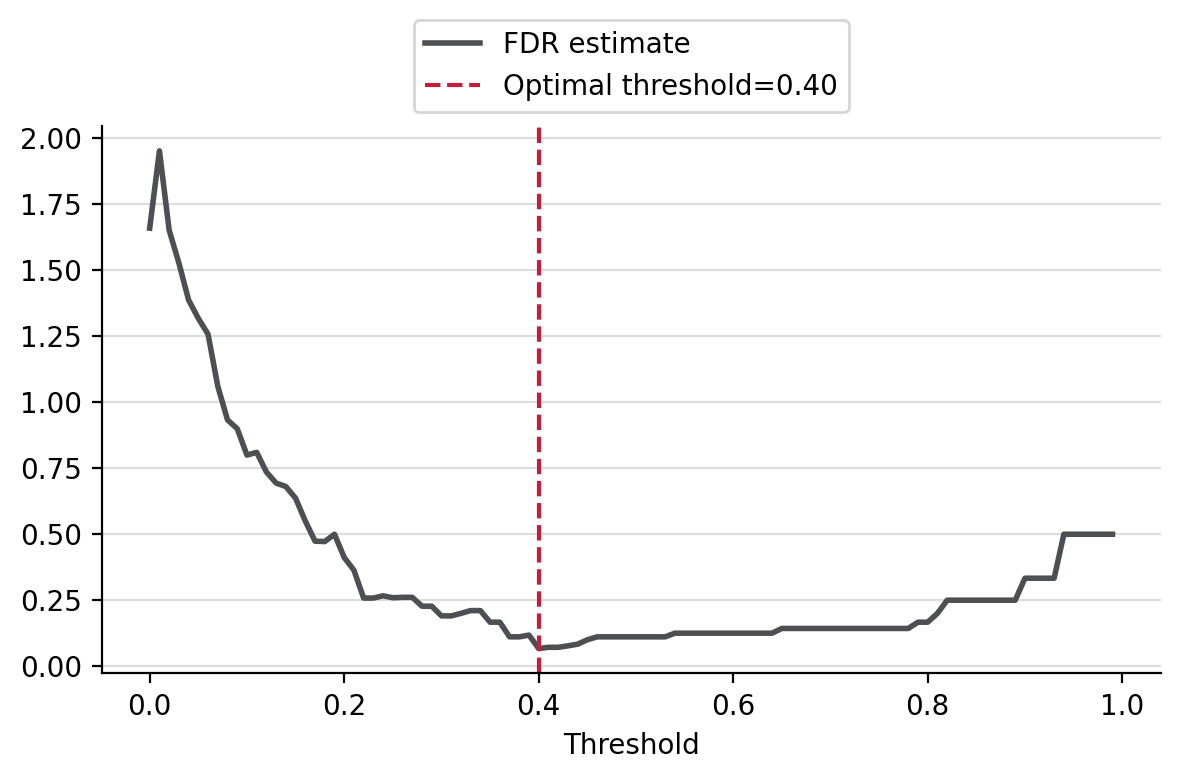

In [15]:
plot_fdr_graph(stabl_regression, figsize=(6, 4))

**Visualizing the STABL path**

(<Figure size 400x800 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>)

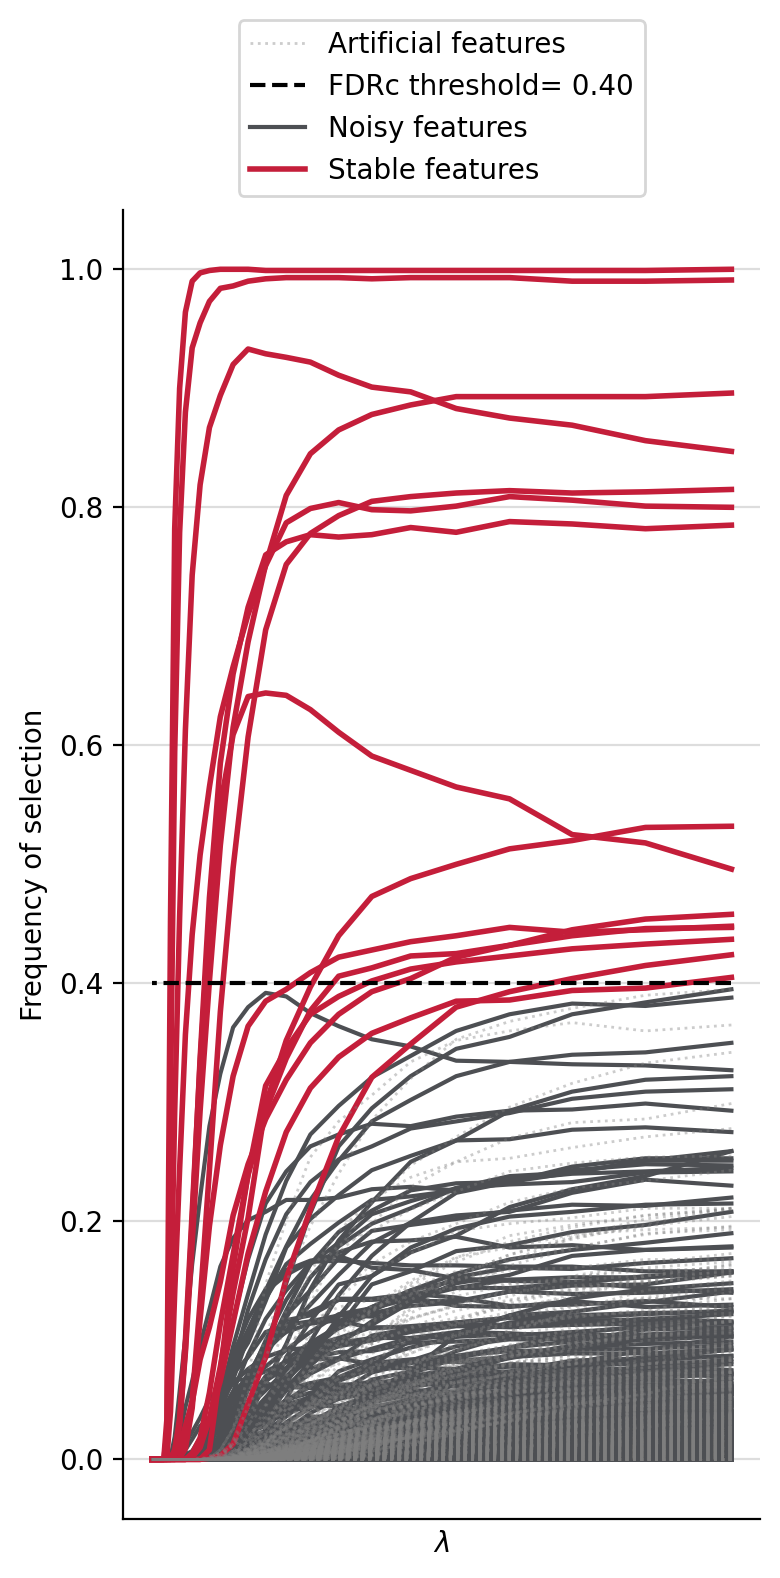

In [16]:
plot_stabl_path(stabl_regression, figsize=(4,8))

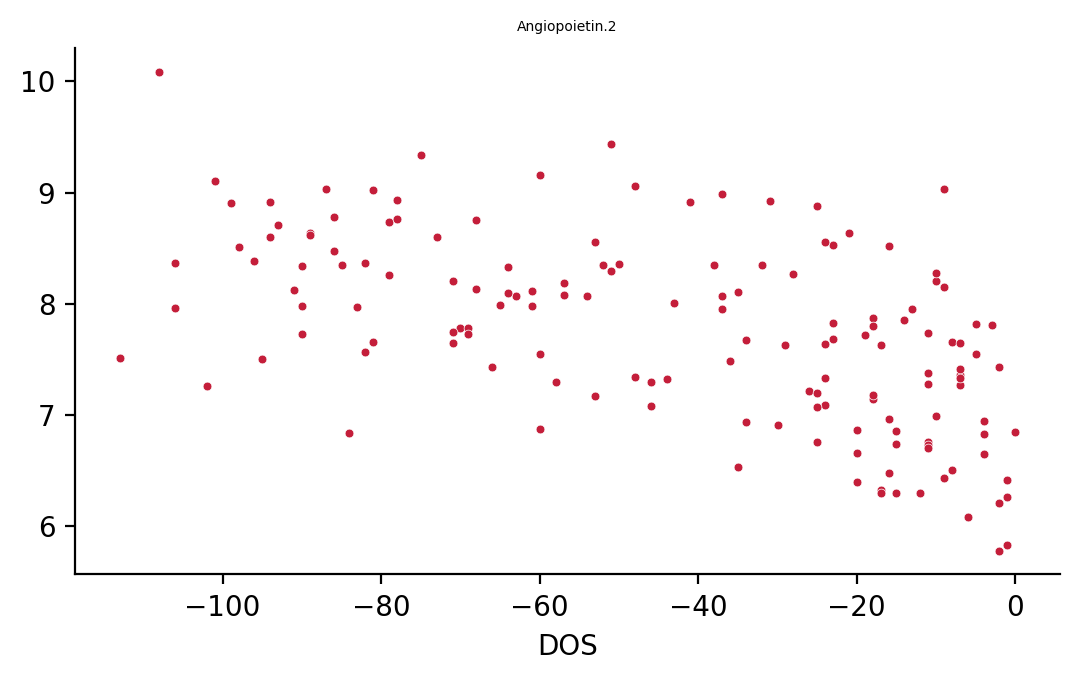

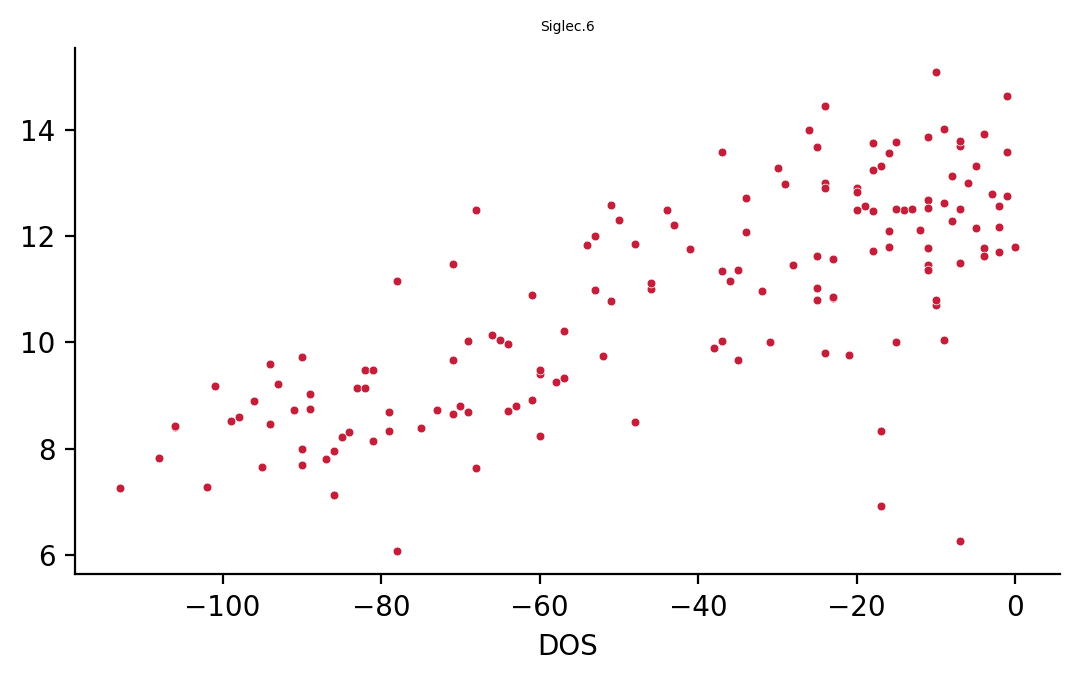

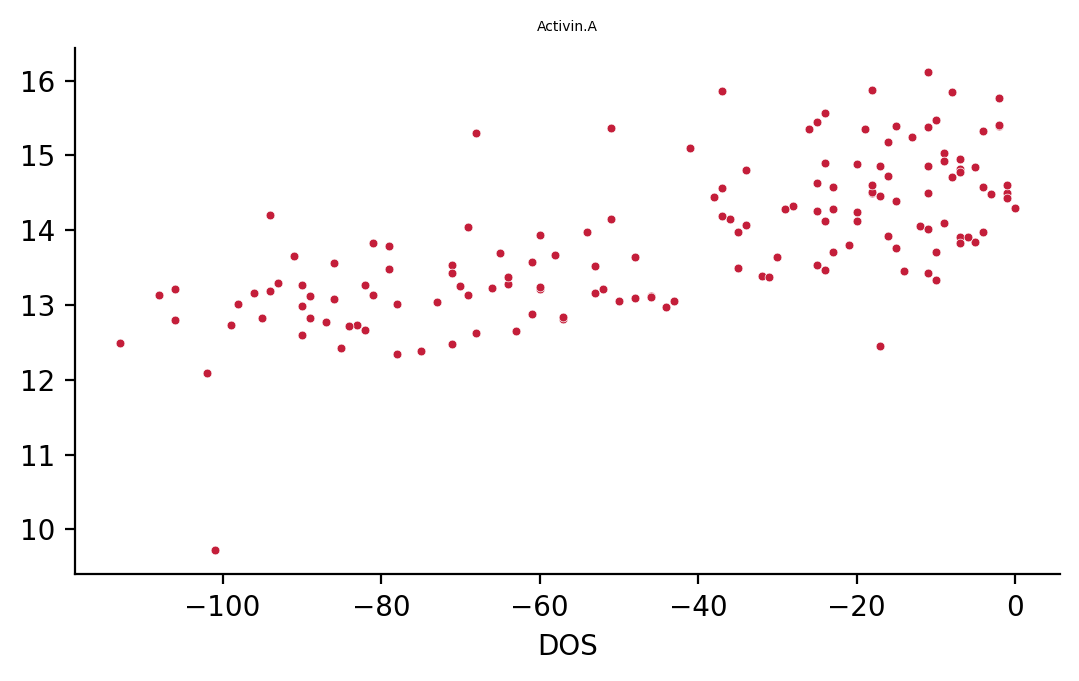

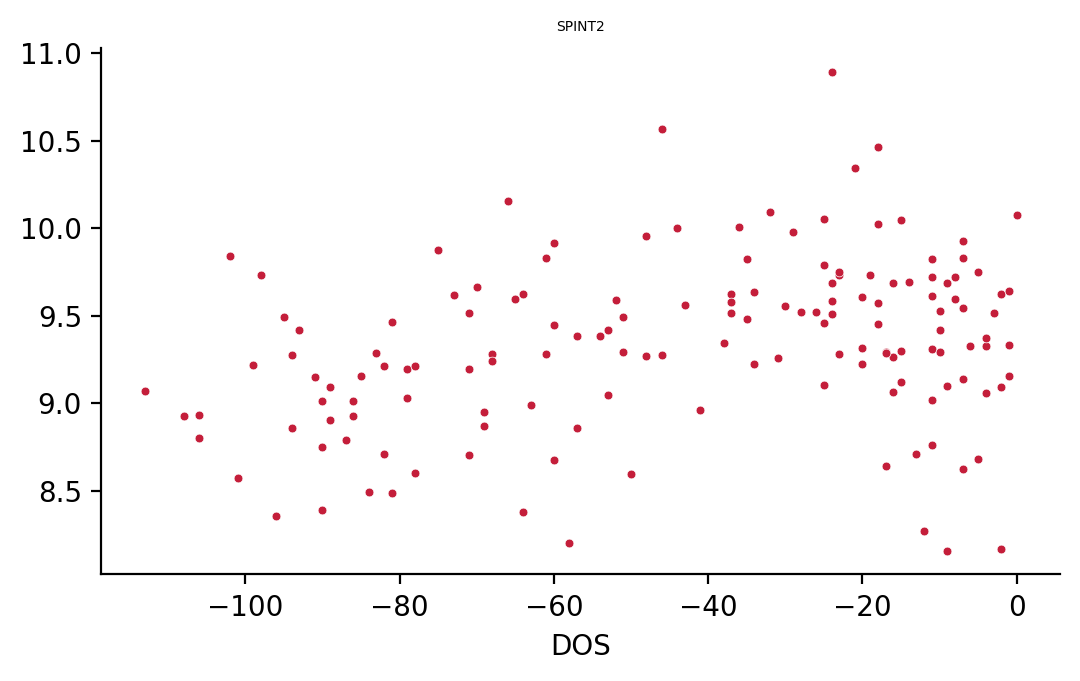

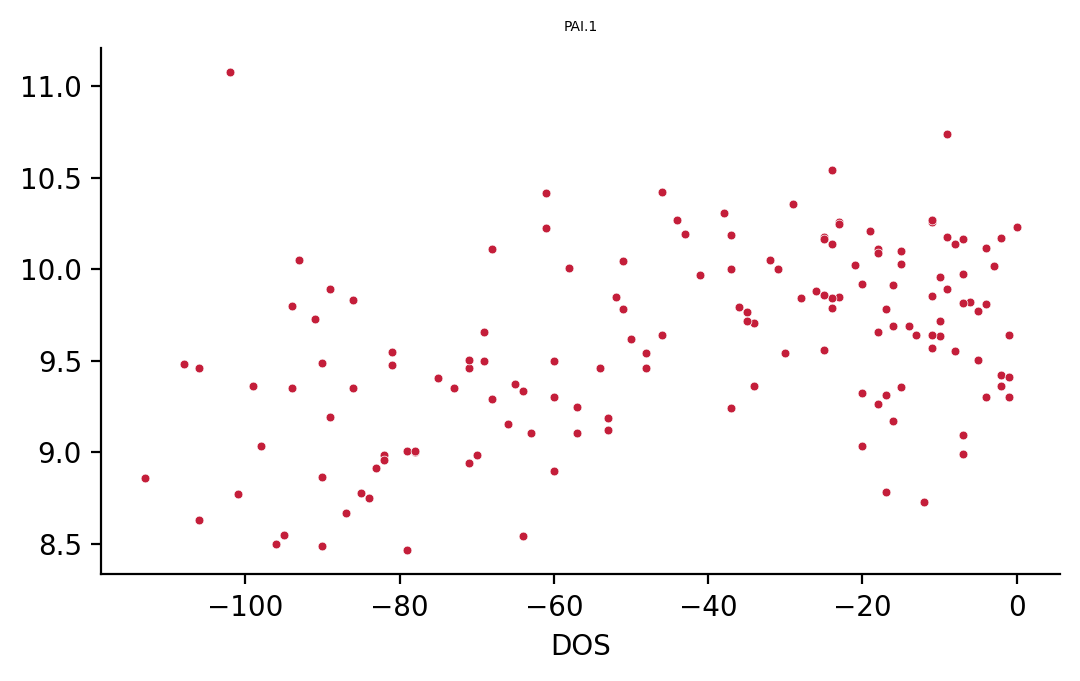

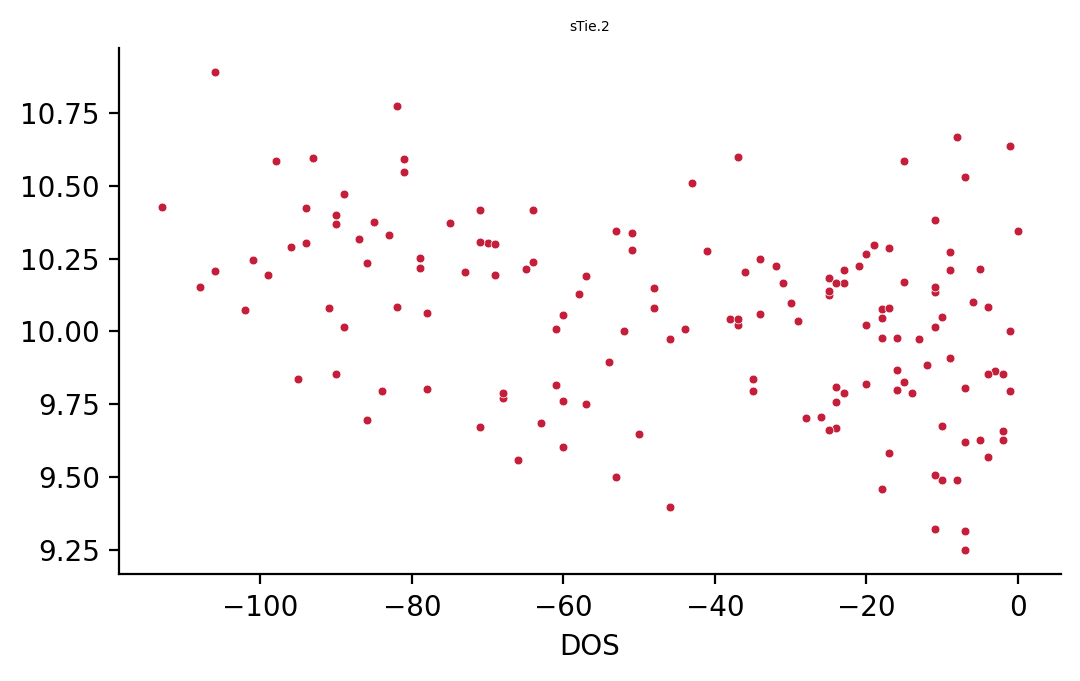

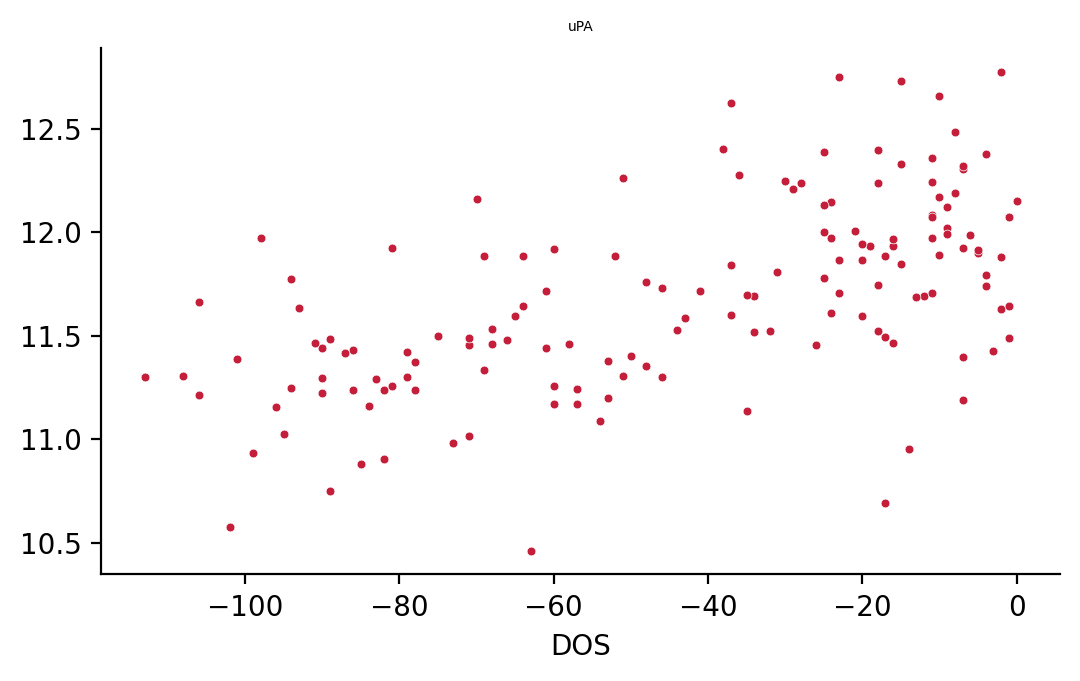

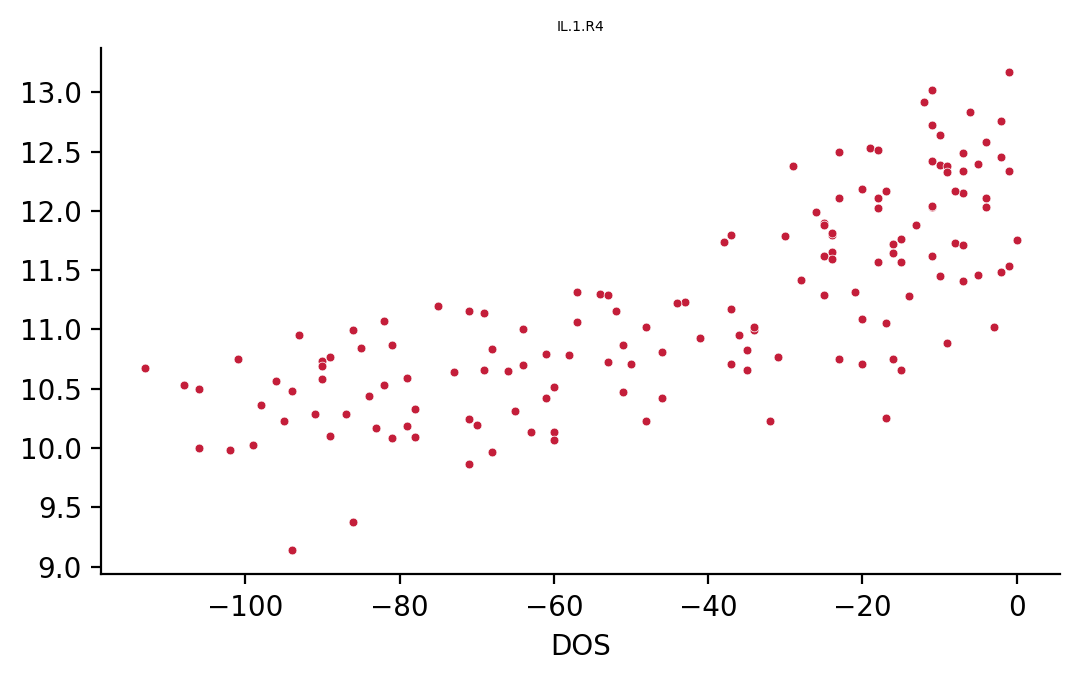

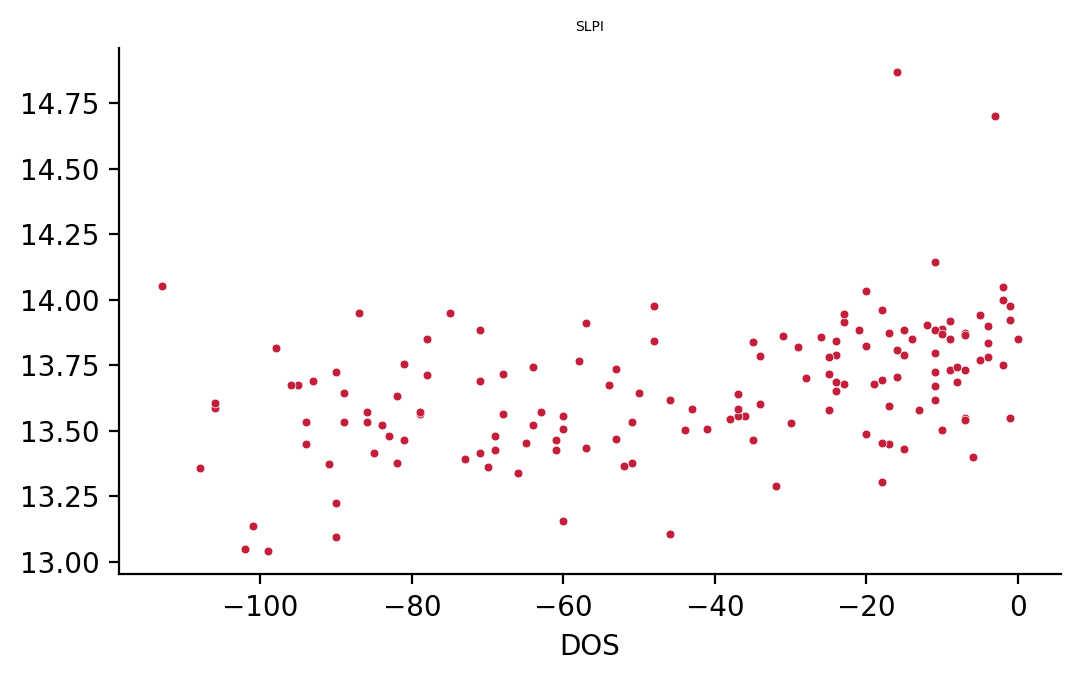

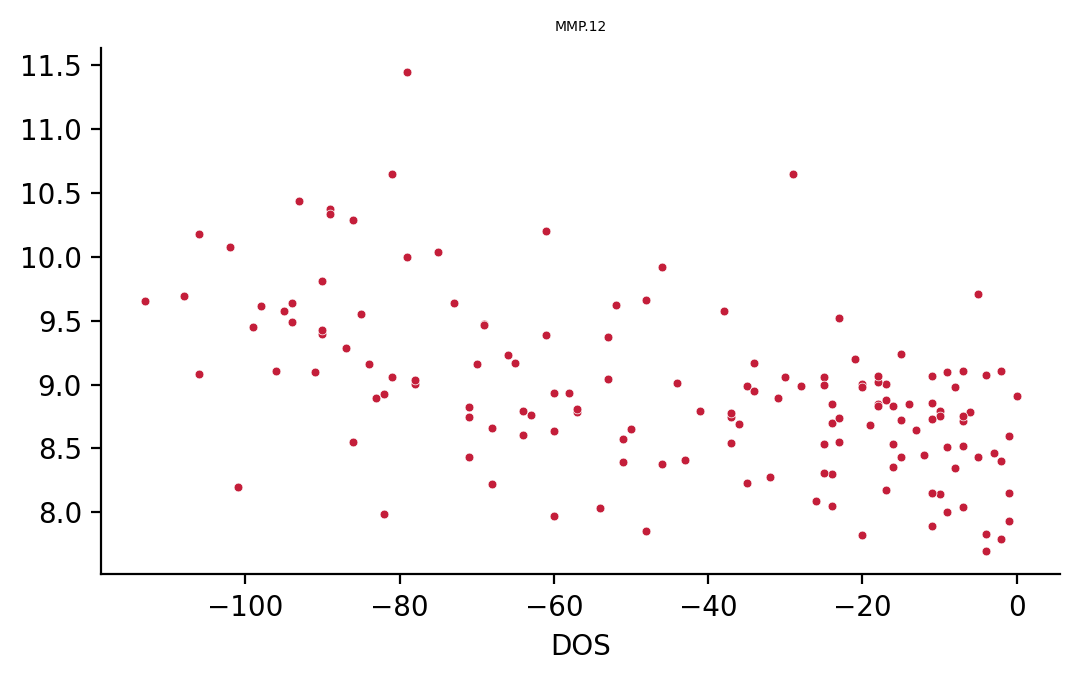

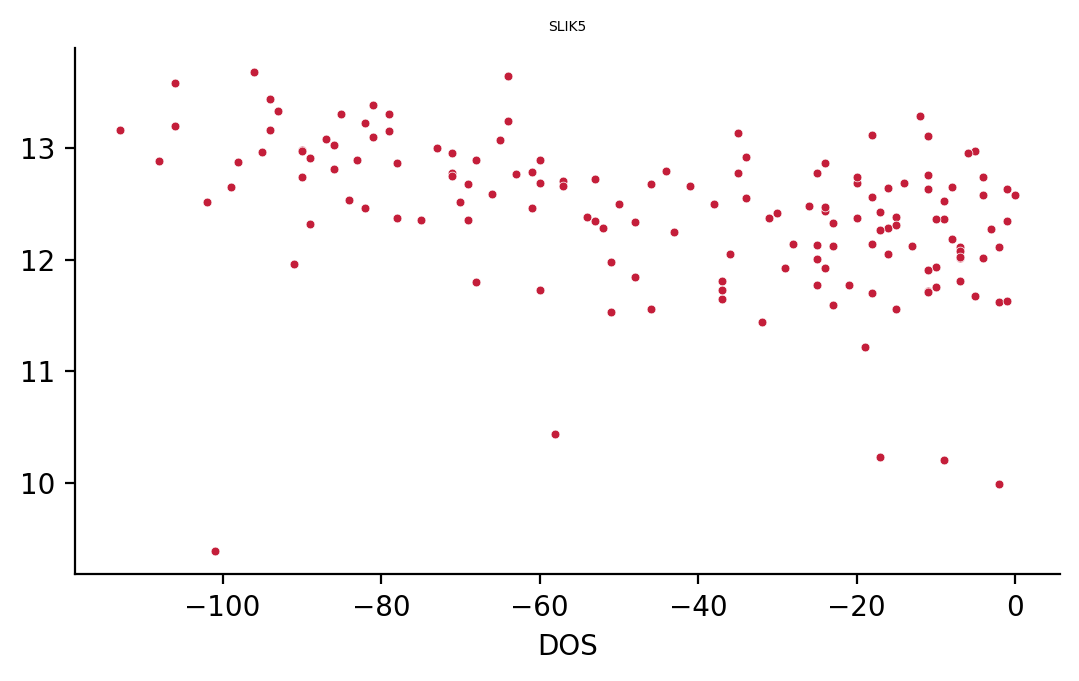

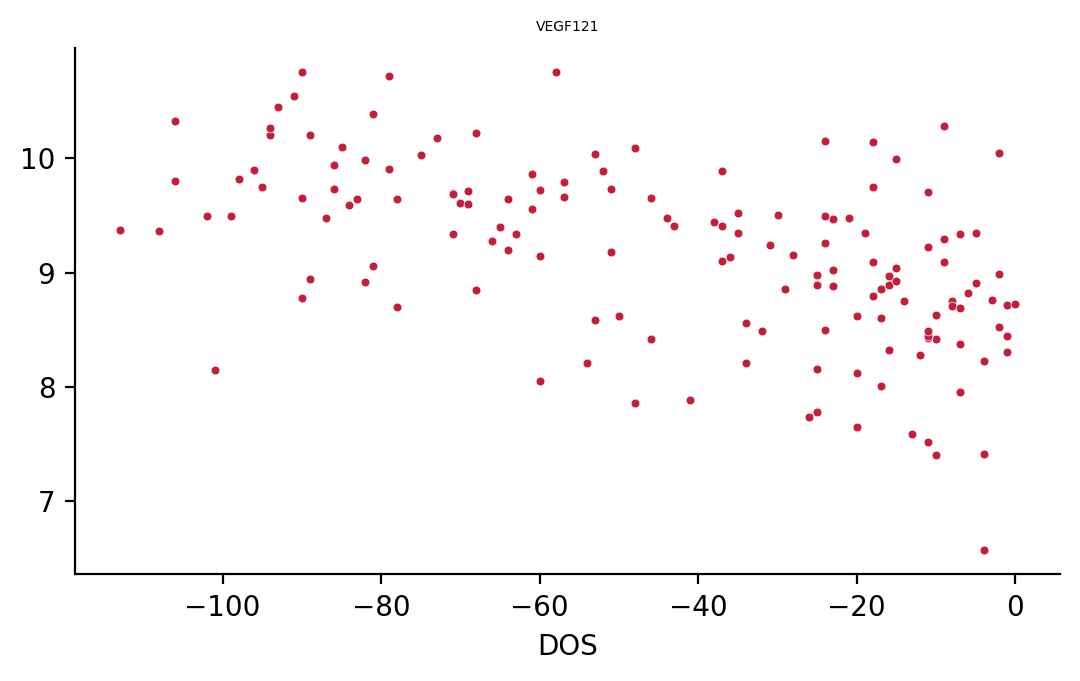

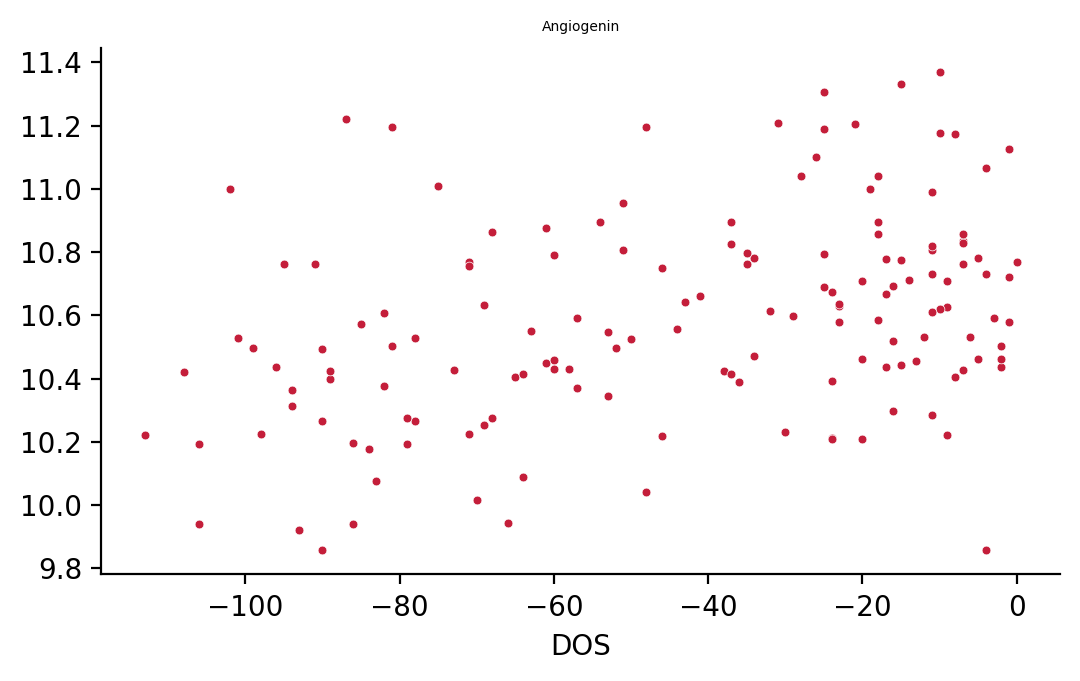

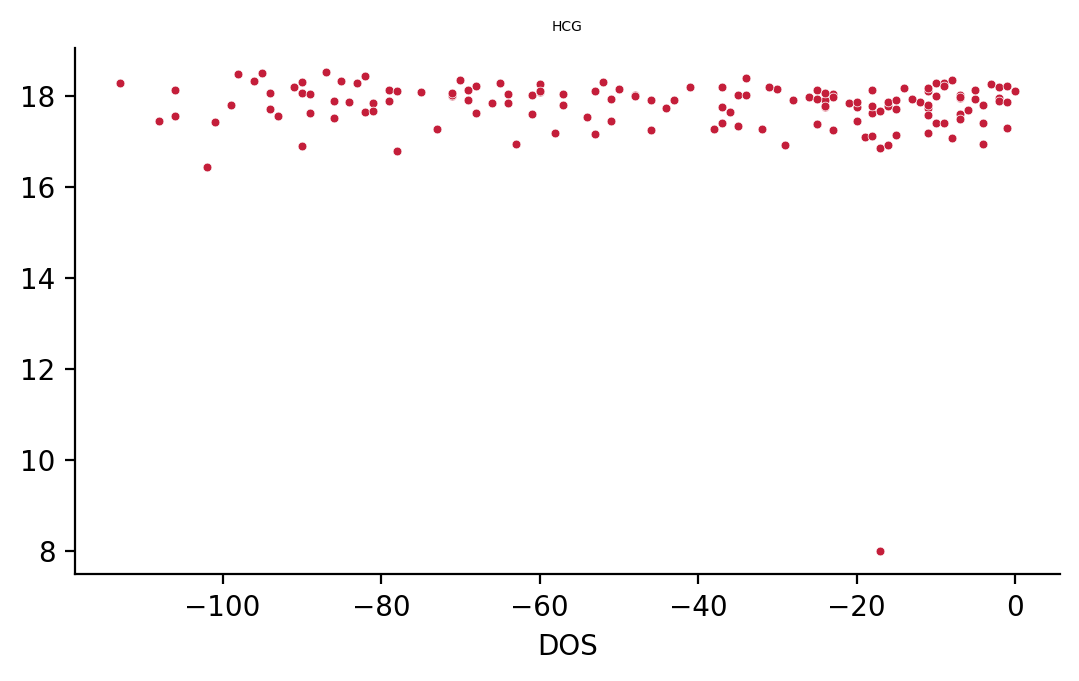

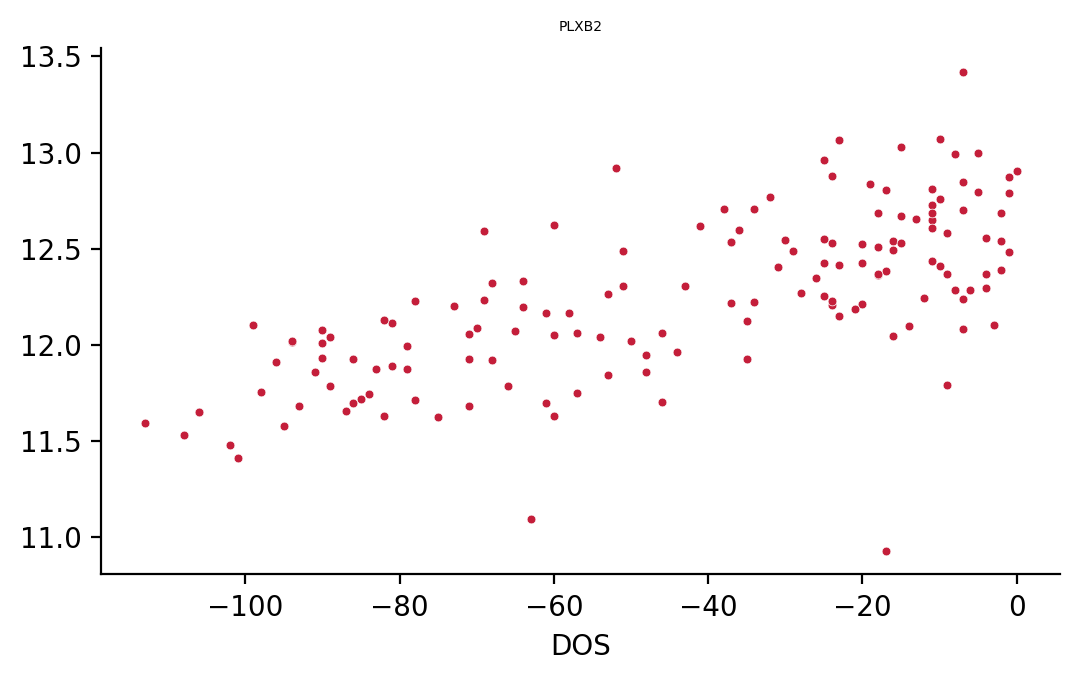

In [17]:
scatterplot_features(
    list_of_features=stabl_regression.get_feature_names_out(),
    df_X=prot_ool,
    y=DOS_ool
)

Model
---
(Jonas)

**Looking at the selected features**

In [18]:
best_scores = dict([(list(prot_ool.columns)[i], (stabl_regression.stabl_scores_[i, :]).max()) for i in range(1317)])
alpha_max = dict([(list(prot_ool.columns)[i], np.argmax(stabl_regression.stabl_scores_[i, :])) for i in range(1317)])

resum = pd.DataFrame(columns=['features', 'f_max', 'alpha_max', 'FDP+ (threshold=0.4)'])
resum['features'] = stabl_regression.get_feature_names_out()
resum.set_index = resum['features']

f_max = []
for feature in resum['features']:
    f_max.append(best_scores[feature])

resum['f_max'] = f_max

a_max = []
for feature in resum['features']:
    a_max.append(-alpha_max[feature])
    
resum['alpha_max'] = np.logspace(0, 2, 30)[a_max]

FDPs = []
artificial_proportion = stabl_regression.artificial_proportion
for i in a_max:    
    scores_artificial = stabl_regression.stabl_scores_artificial_[:,-i]
    scores = stabl_regression.stabl_scores_[:,-i]
    num = np.sum((1 / artificial_proportion) * (scores_artificial > stabl_regression.fdr_min_threshold_)) + 1
    denum = max([1, np.sum((scores > stabl_regression.fdr_min_threshold_))])
    FDP = num / denum
    FDPs.append(FDP)

resum['FDP+ (threshold=0.4)'] = FDPs

resum = resum.sort_values('FDP+ (threshold=0.4)')


In [19]:
resum

,features,f_max,alpha_max,FDP+ (threshold=0.4)
0,Angiopoietin.2,0.896,1.000000,0.066667
3,SPINT2,0.424,1.000000,0.066667
4,PAI.1,0.405,1.000000,0.066667
5,sTie.2,0.532,1.000000,0.066667
6,uPA,0.458,1.000000,0.066667
7,IL.1.R4,1.000,1.000000,0.066667
8,SLPI,0.815,1.000000,0.066667
10,SLIK5,0.448,1.000000,0.066667
12,Angiogenin,0.447,1.000000,0.066667
13,HCG,0.437,1.000000,0.066667


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Pearson r: score = 0.890, pvalue= 5.853e-18\nR2-score = 0.791, RMSE = 14.532, MAE = 10.354'}, xlabel='DOS'>)

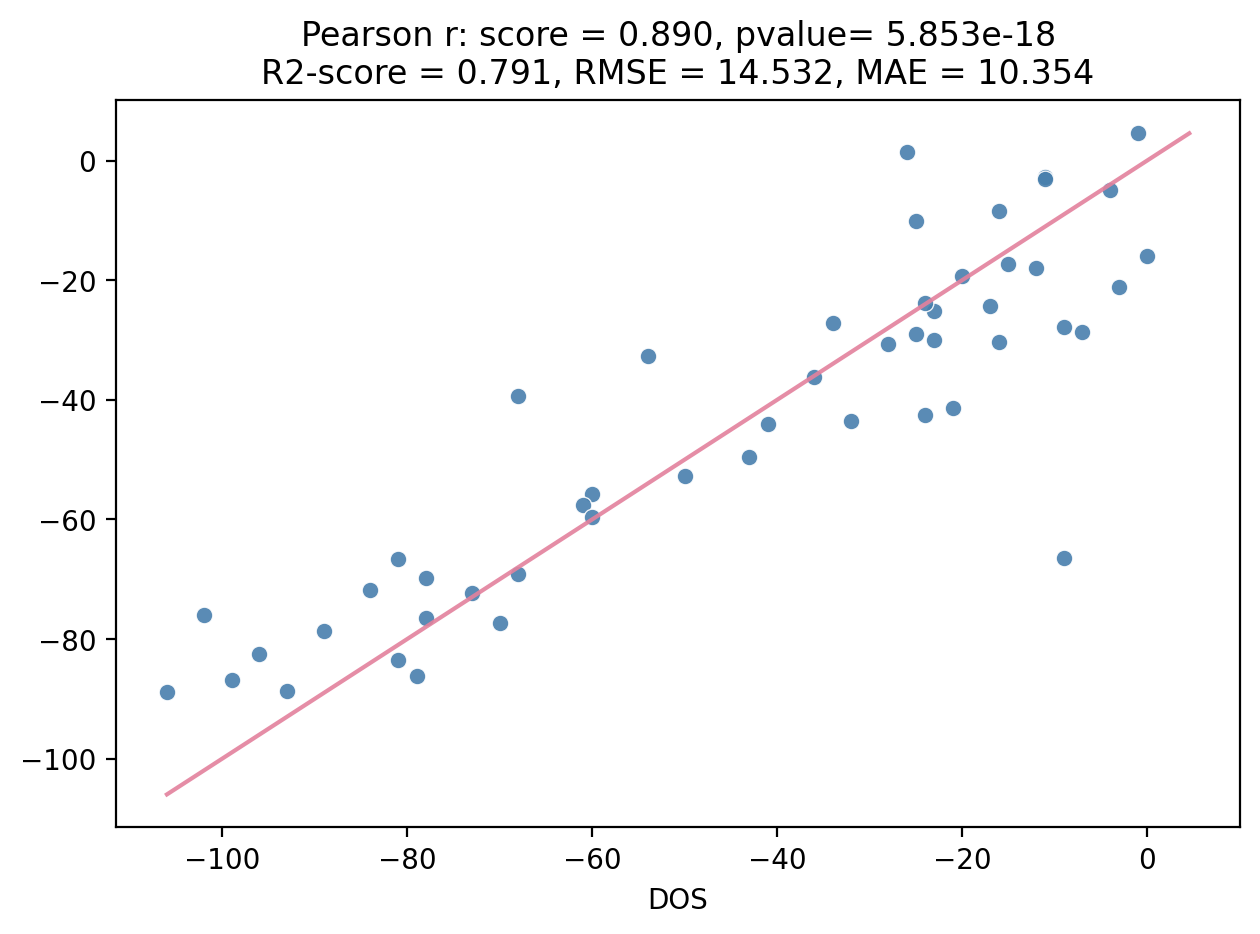

In [20]:
alpha = resum['alpha_max'][0]

X = prot_std[stabl_regression.get_feature_names_out()]

X_train, X_test, y_train, y_test = train_test_split(X,DOS_ool, test_size=0.33, random_state=42)

clf = Lasso(alpha=alpha)
clf.fit(X_train, y_train)

scatterplot_regression_predictions(y_test,clf.predict(X_test))



In [21]:
CV_lasso = nonpartition_cross_val_predict(
    Lasso(alpha=alpha),
    prot_std[stabl_regression.get_feature_names_out()],
    DOS_ool,
    "regression",
    RepeatedStratifiedKFold(n_splits=6, n_repeats=2, random_state=None))

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Pearson r: score = 0.910, pvalue= 2.540e-58\nR2-score = 0.827, RMSE = 13.375, MAE = 9.726'}, xlabel='DOS'>)

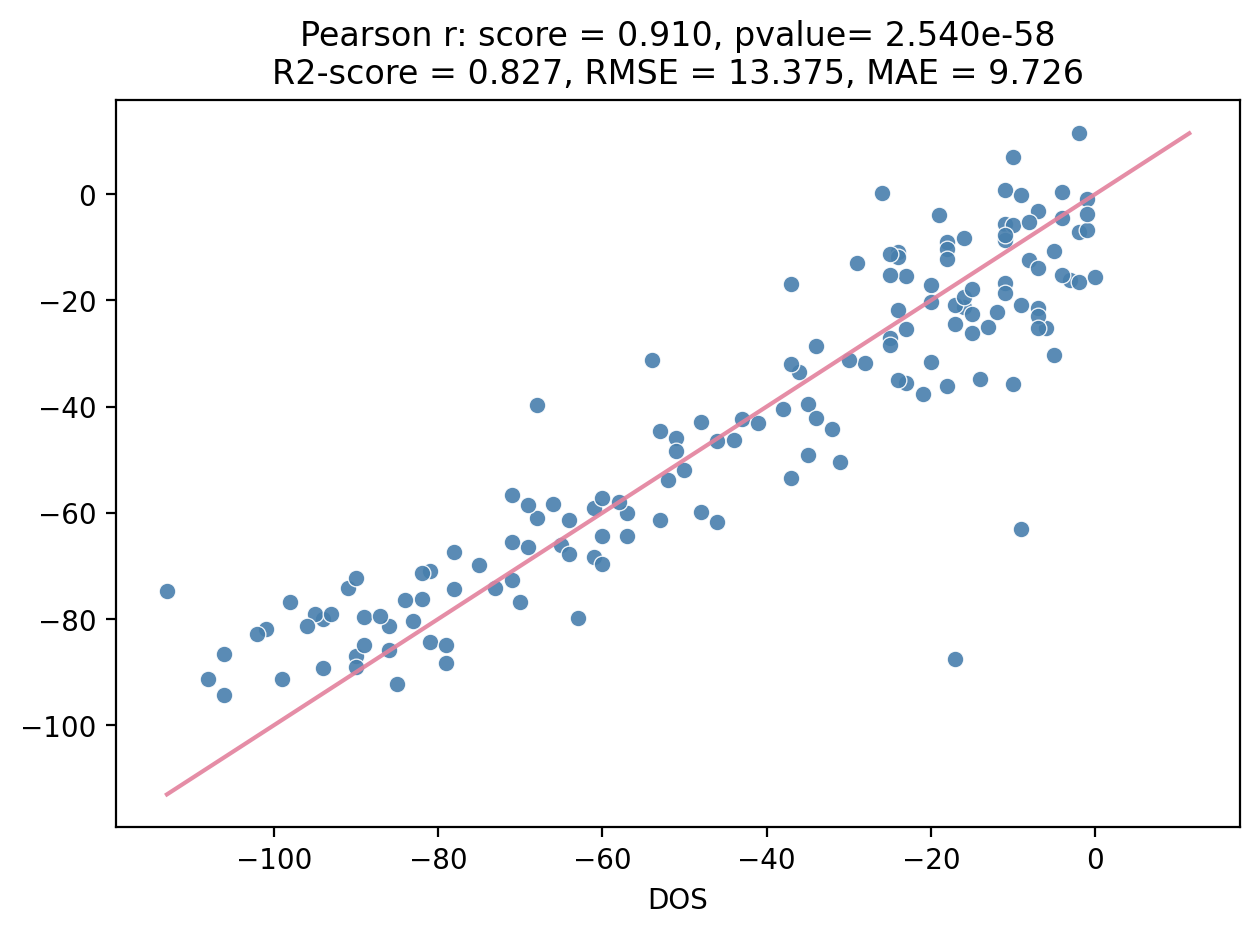

In [22]:
scatterplot_regression_predictions(DOS_ool,CV_lasso[1])

**Visualizing the selected features using the `scatterplot_features` function of the `visualization.py` file**

## STABL on a binary classification task

### Example on the Covid proteomics file

In [23]:
common_indices = prot_covid.index.intersection(covid_pos.index)

In [24]:
stabl_class = Stabl(
    base_estimator=clone(logit_lasso),
    lambda_name="C",
    lambda_grid=np.linspace(0.01, 1, 30),
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    n_bootstraps=1000,
    random_state=42
)

In [25]:
prot_covid_std = pd.DataFrame(
    data=preprocessing.fit_transform(prot_covid),
    index=prot_covid.index,
    columns=preprocessing.get_feature_names_out()
)

prot_covid_std=prot_covid_std.loc[common_indices]

In [26]:
prot_covid_std

,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,ACTA2,...,WNT9A,WWP2,XCL1,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17
sampleID,,,,,,,,,,,,,,,,,,,,,
007-0003,-1.413596,-0.661923,-0.330325,0.192978,-0.608791,-0.110748,-0.423223,0.436216,0.425750,-1.387493,...,-0.544451,-0.601160,1.091873,-1.727985,-0.332874,0.632369,-0.578804,-0.625434,0.042340,0.670296
007-0005,1.350872,1.478741,1.530663,1.358590,-0.973275,0.024210,1.894089,-0.530485,2.180332,0.038694,...,-0.971062,1.470928,-0.120692,-0.017721,-0.010842,1.469079,1.511223,1.620222,2.217500,0.967558
007-0007,0.339873,-0.632202,-0.231489,-0.541324,-0.589043,-0.402815,-1.057014,-0.405910,-0.369602,-0.089053,...,0.037145,0.014971,0.642650,-0.287370,0.241729,0.774544,-1.031211,-0.403604,-0.393882,2.100771
007-0008,1.119243,1.262435,1.107904,0.808026,0.038085,-0.956556,0.969117,0.966527,1.531961,0.036697,...,-1.340674,1.017157,-1.402799,-1.232894,1.803546,0.499418,0.997507,0.787619,1.931530,1.078590
007-0009,-0.124822,1.236036,1.203667,0.421423,2.621636,0.207460,0.336952,2.786174,1.585265,2.935648,...,3.187077,0.880726,2.370621,4.303787,-0.262311,1.034912,0.952325,0.559592,1.796841,2.637854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55689-0112,0.394549,0.903997,1.210920,1.096276,-0.686088,0.073918,1.290204,1.455663,1.035334,-0.747761,...,-0.864115,1.217215,-0.147314,-0.267358,0.313225,0.620247,1.174616,0.829348,1.542111,0.714366
OHC-011,0.580032,0.467893,0.245483,0.057972,1.654850,-0.926938,0.021745,-0.111226,-0.237364,-0.119196,...,-0.025730,0.419775,-0.295604,0.317277,-0.919266,-0.035550,0.521501,0.592751,-0.115465,-0.277971
OHC-025,1.262081,-0.524645,-0.448093,0.164734,0.191834,1.776480,-0.890965,-0.338287,-0.062371,-0.208991,...,0.060356,-0.276440,1.394672,-0.504219,-0.178007,-0.263108,0.124829,-0.256794,-0.817288,-0.621015


In [27]:
stabl_class.fit(prot_covid_std, covid_pos.loc[common_indices])

Stabl(fdr_threshold_range=array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74...
      lambda_grid=array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ]),
      random_state=42)

(<Figure size 400x800 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>)

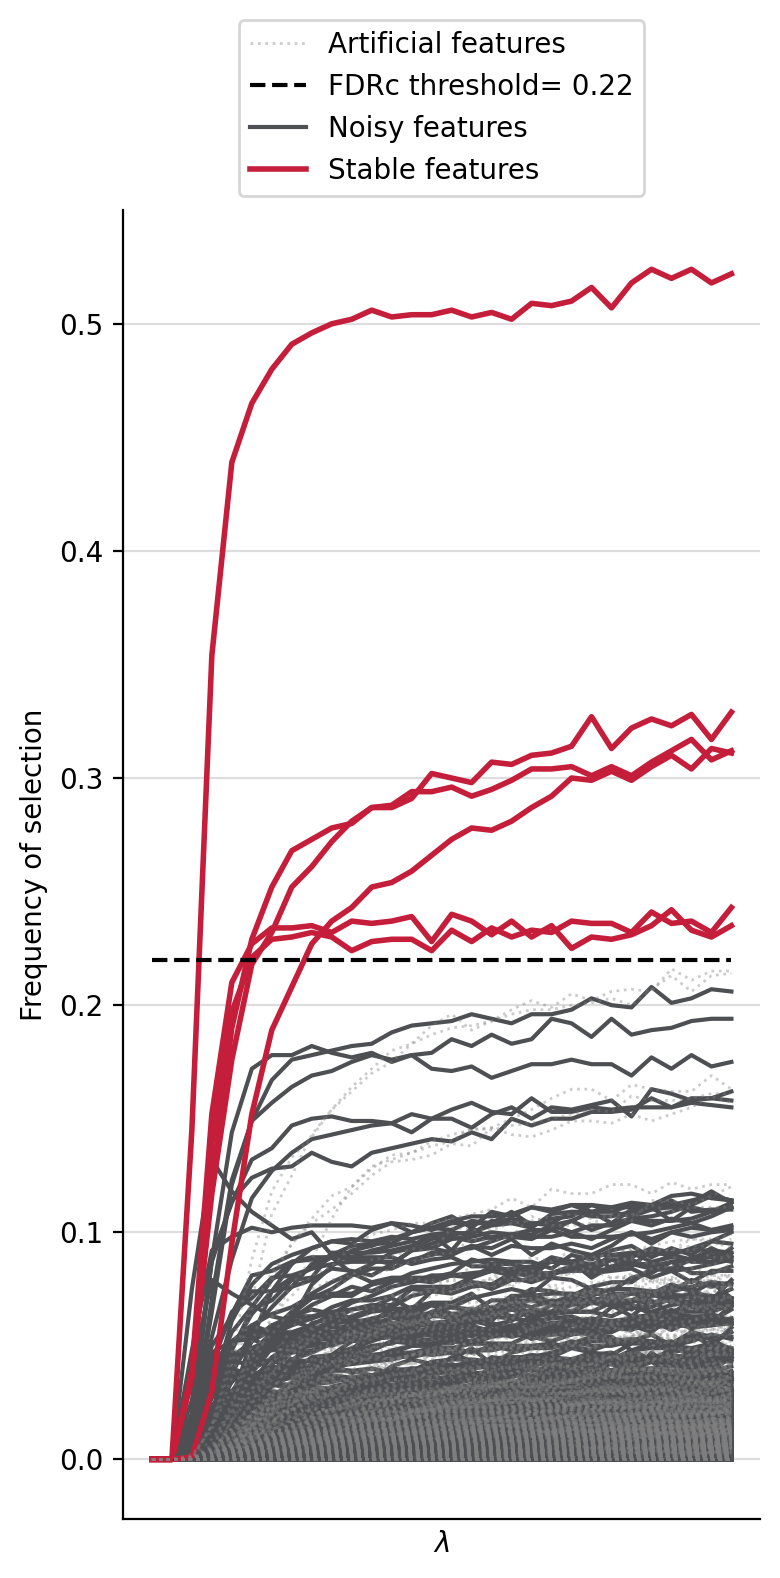

In [28]:
plot_stabl_path(stabl_class)

In [29]:
stabl_class.get_feature_names_out()

array(['CCL20', 'CRTAC1', 'LGALS1', 'MDGA1', 'MZB1', 'PON3'], dtype=object)

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Threshold'>)

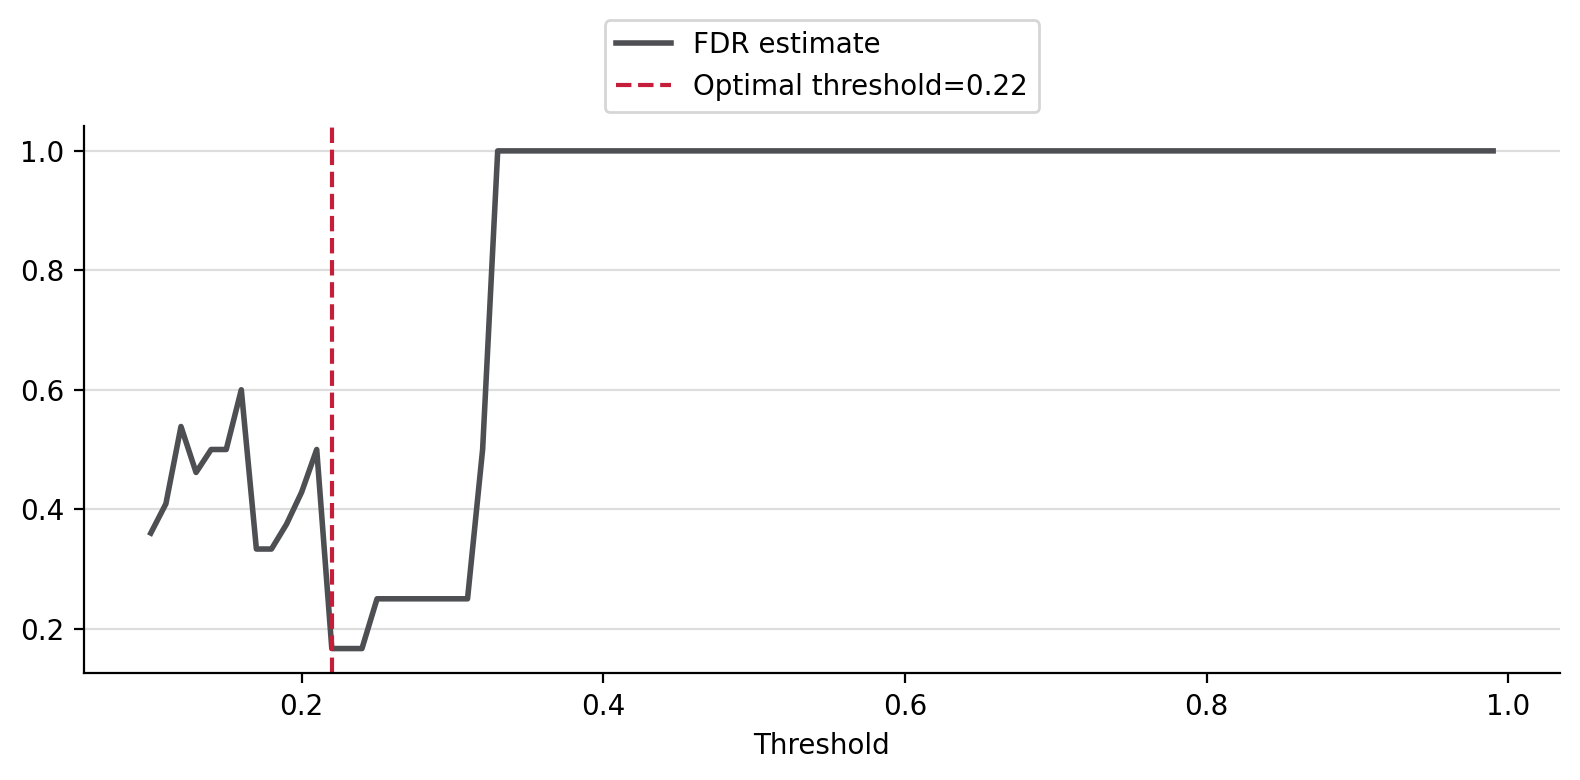

In [30]:
plot_fdr_graph(stabl_class)

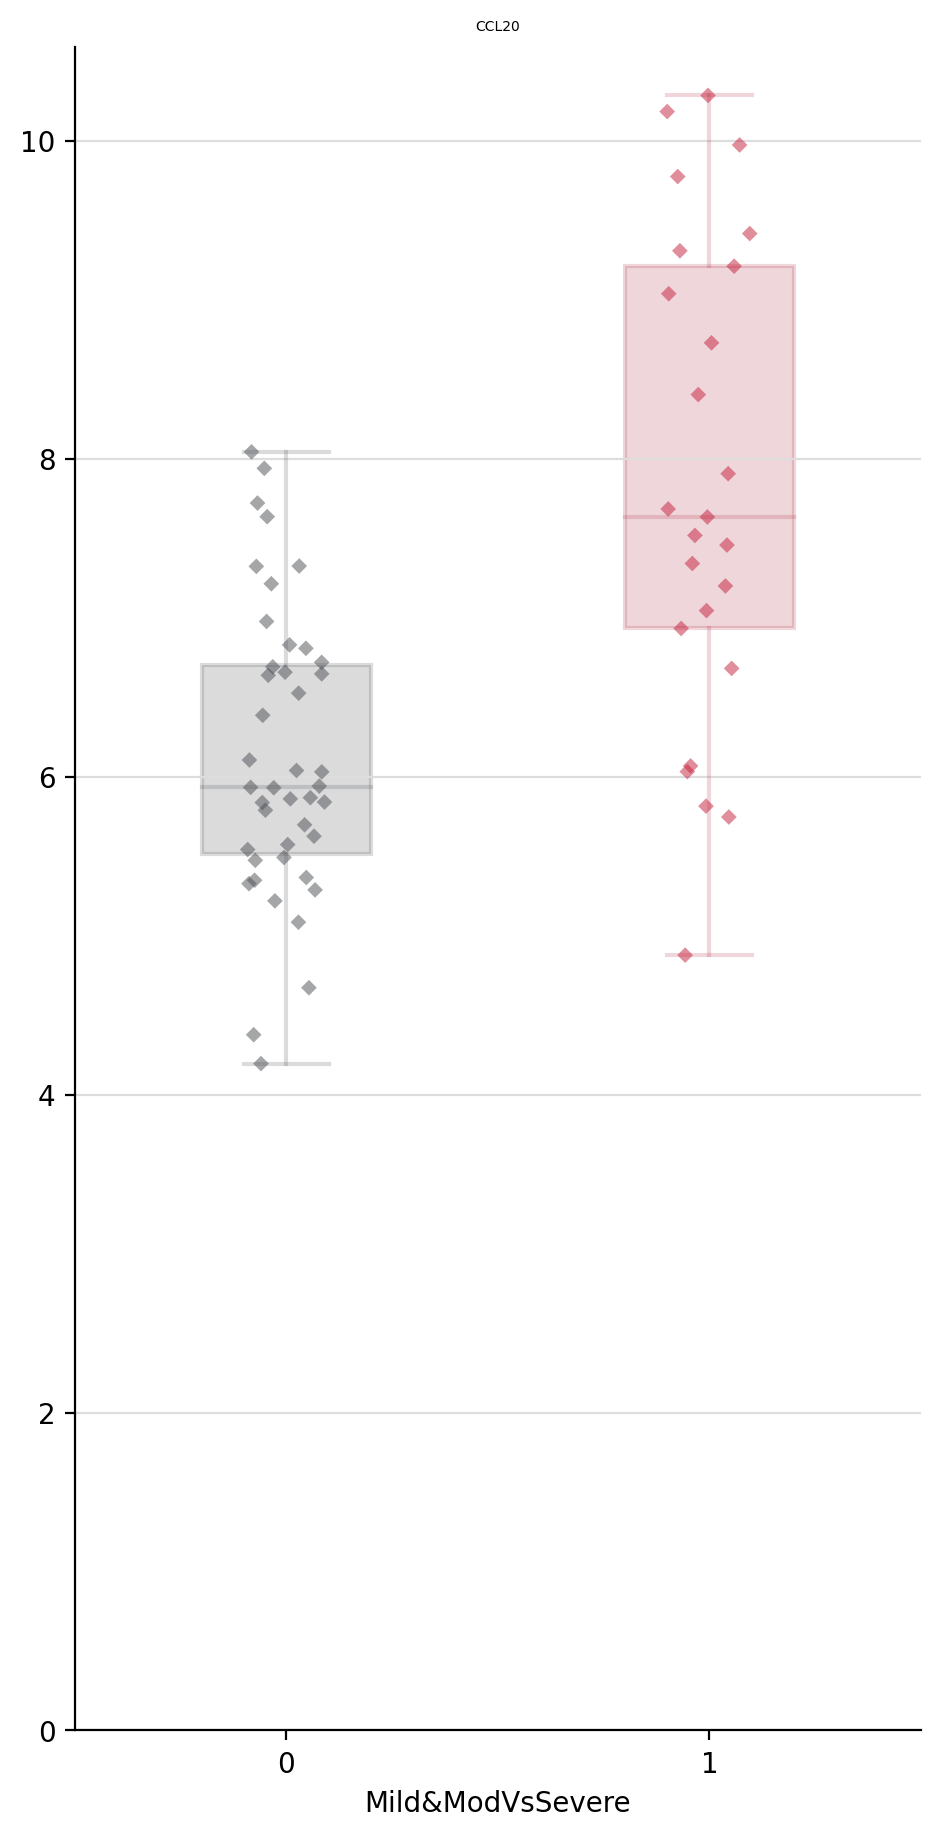

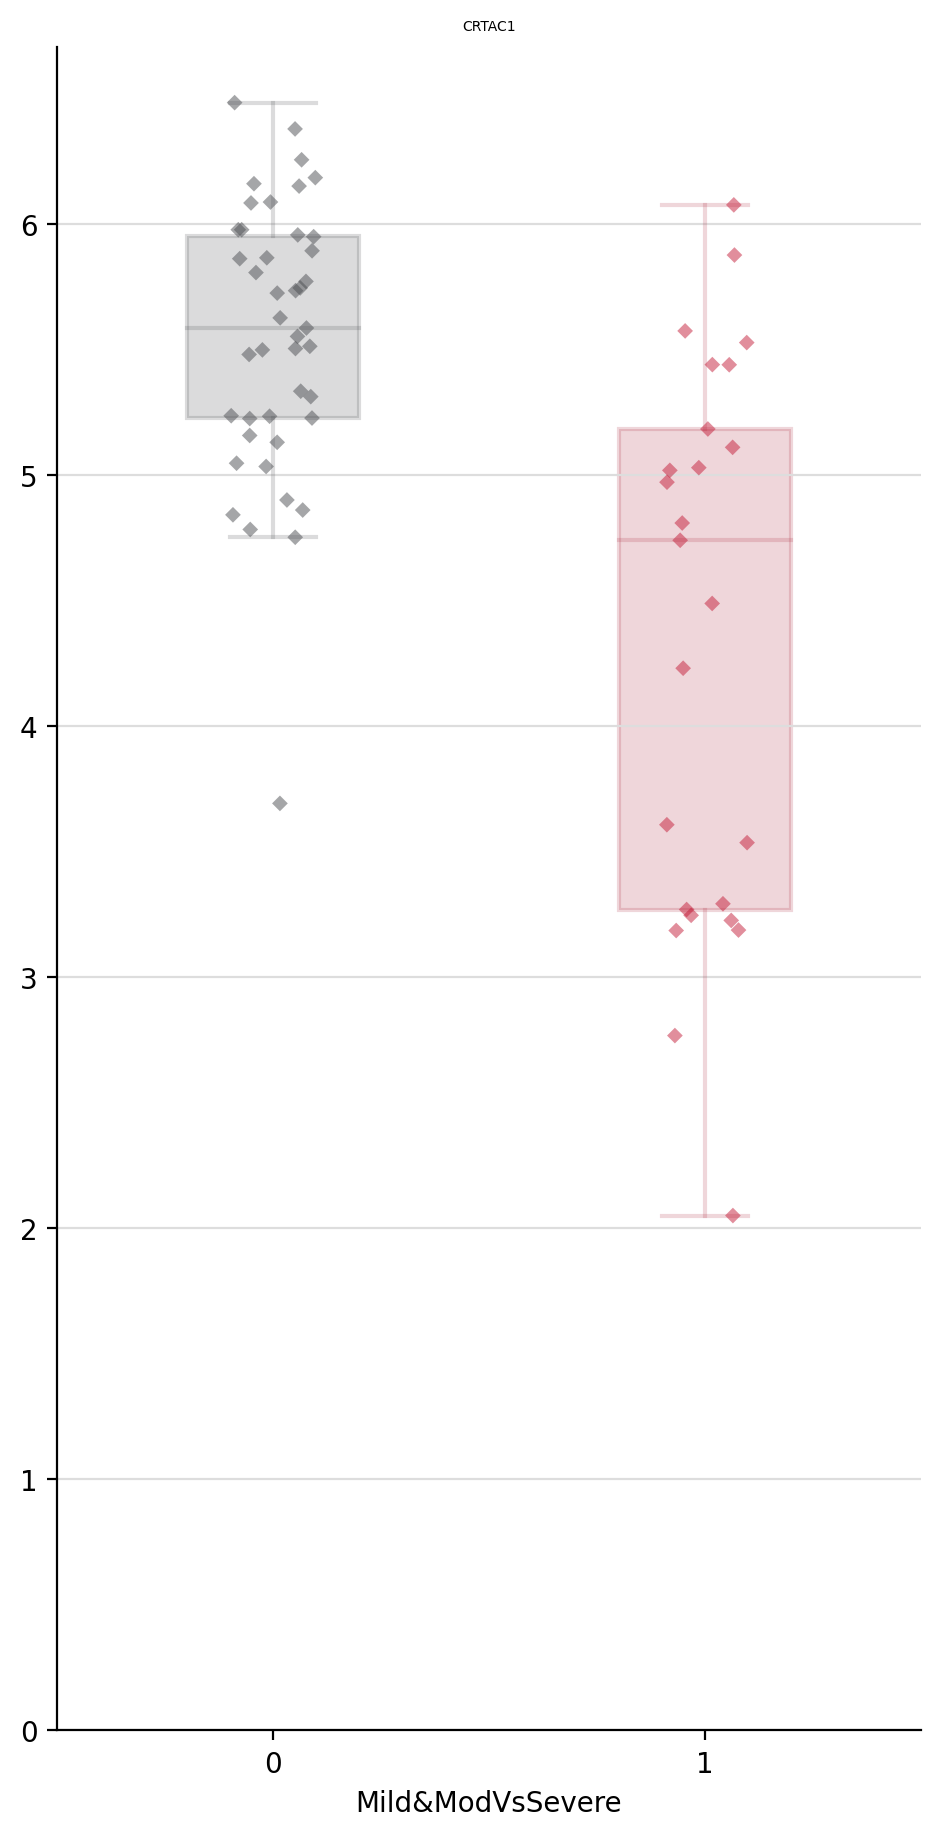

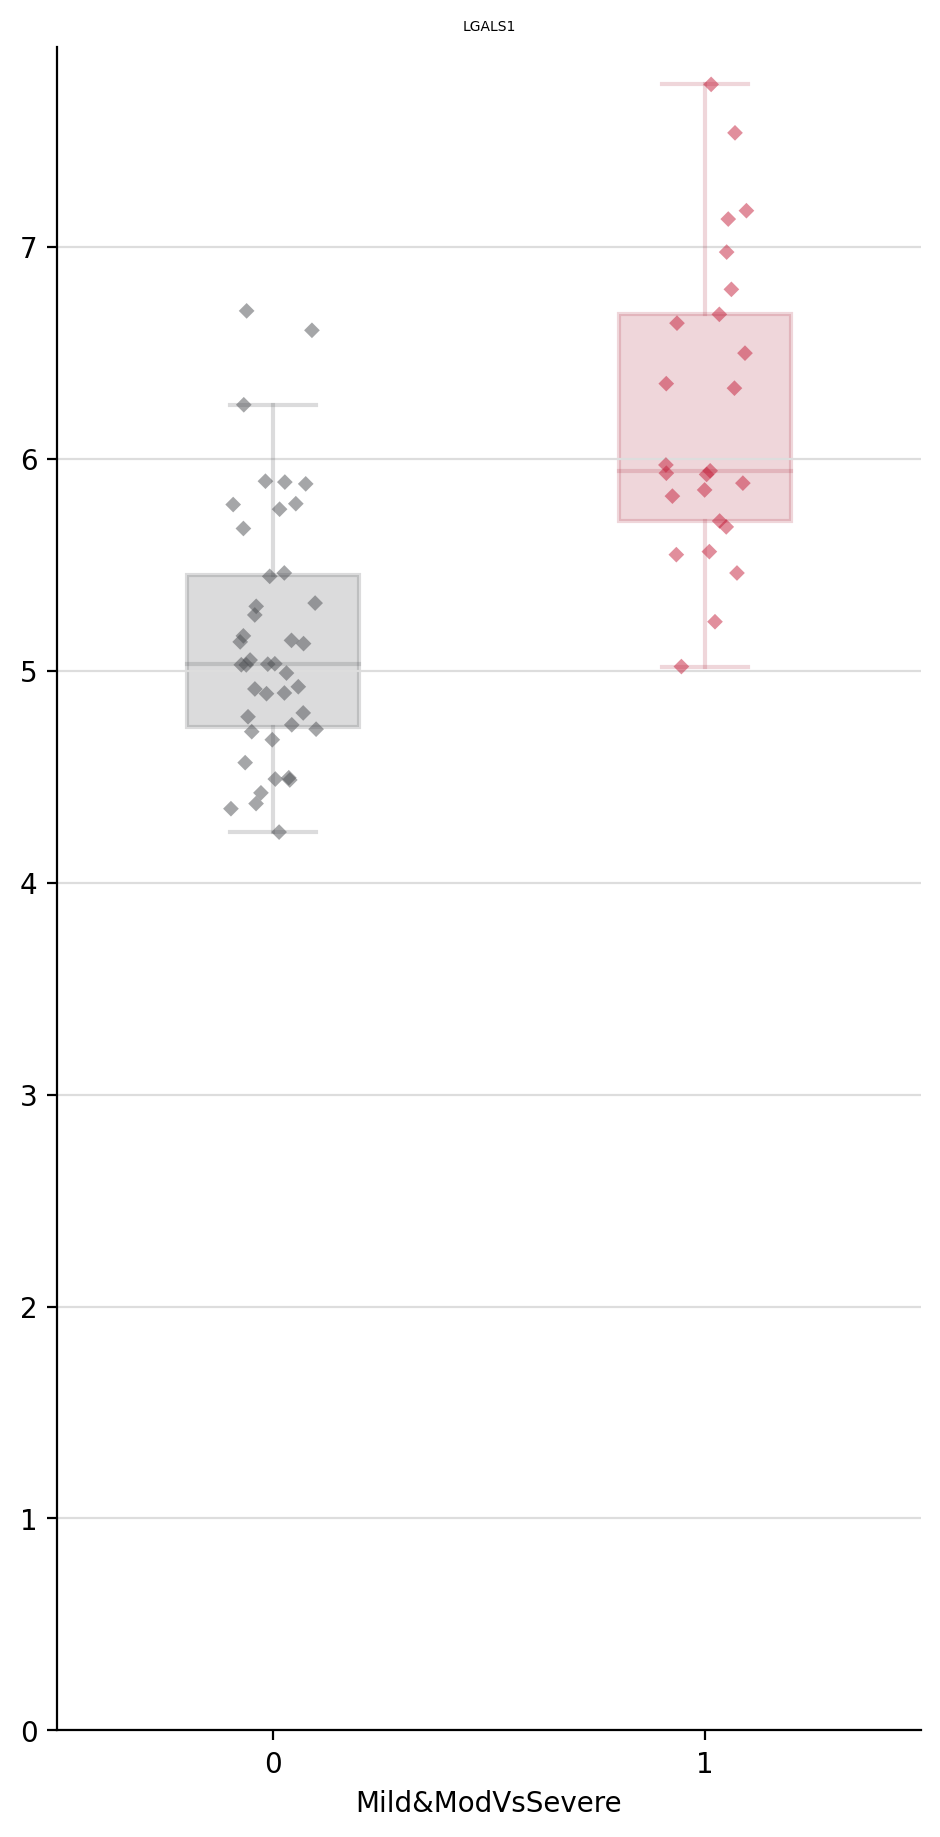

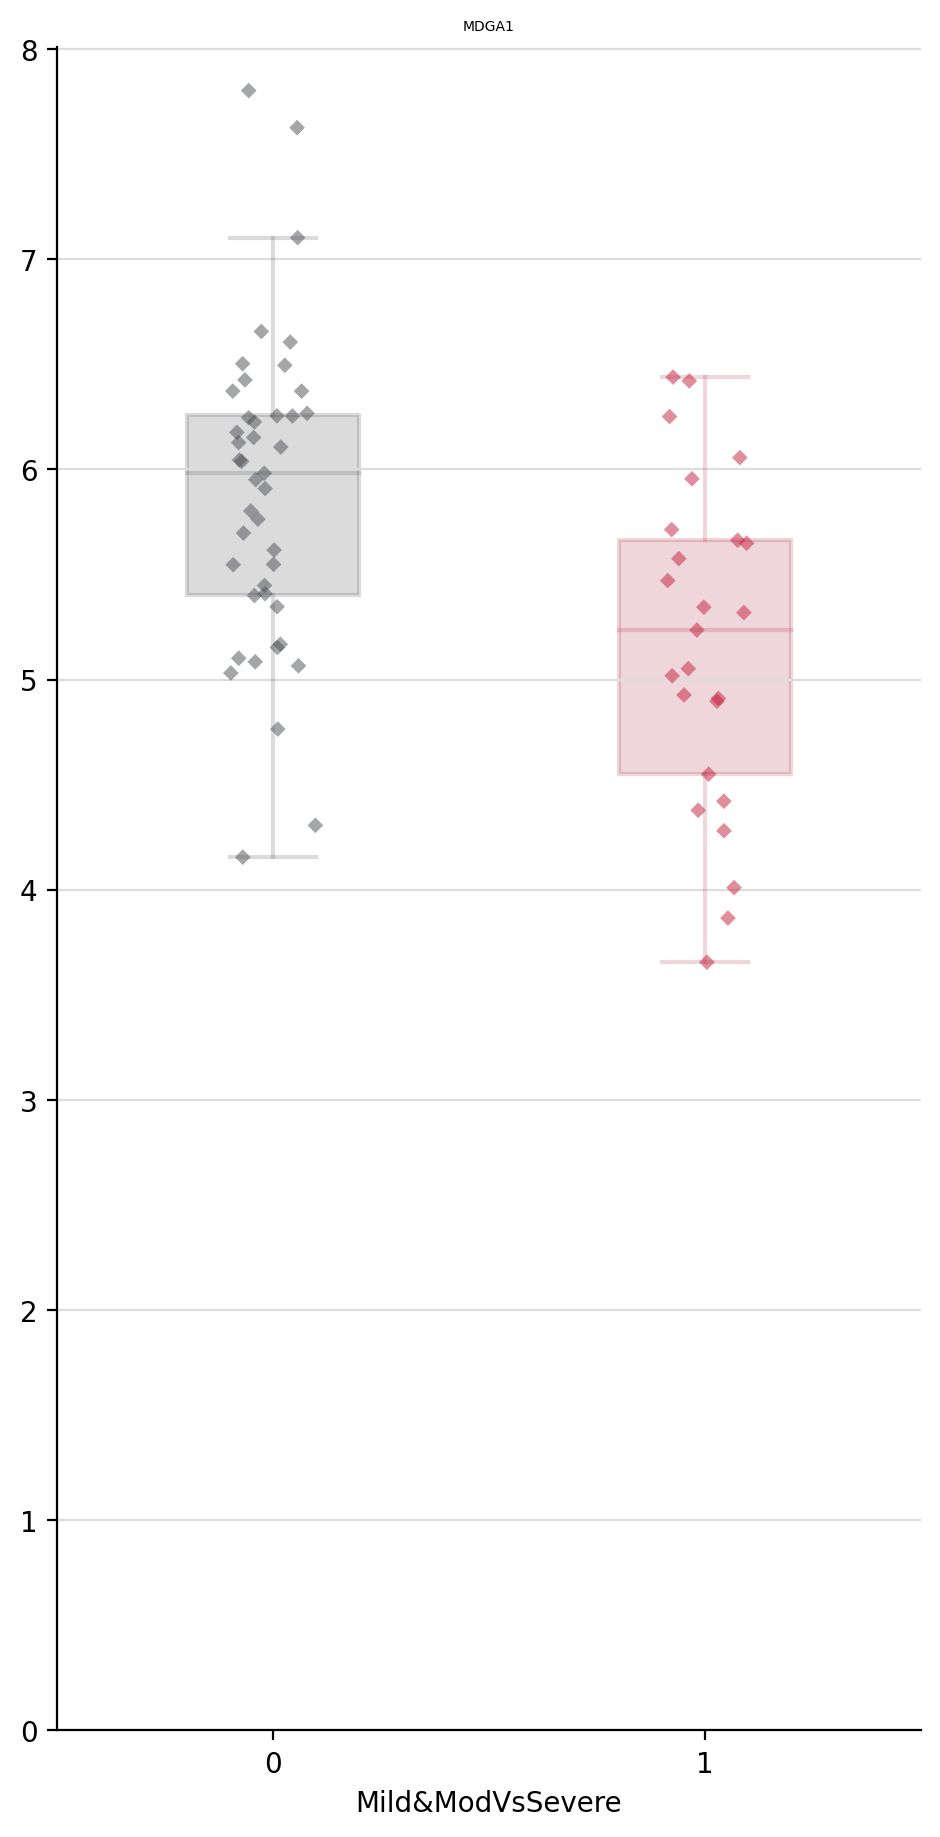

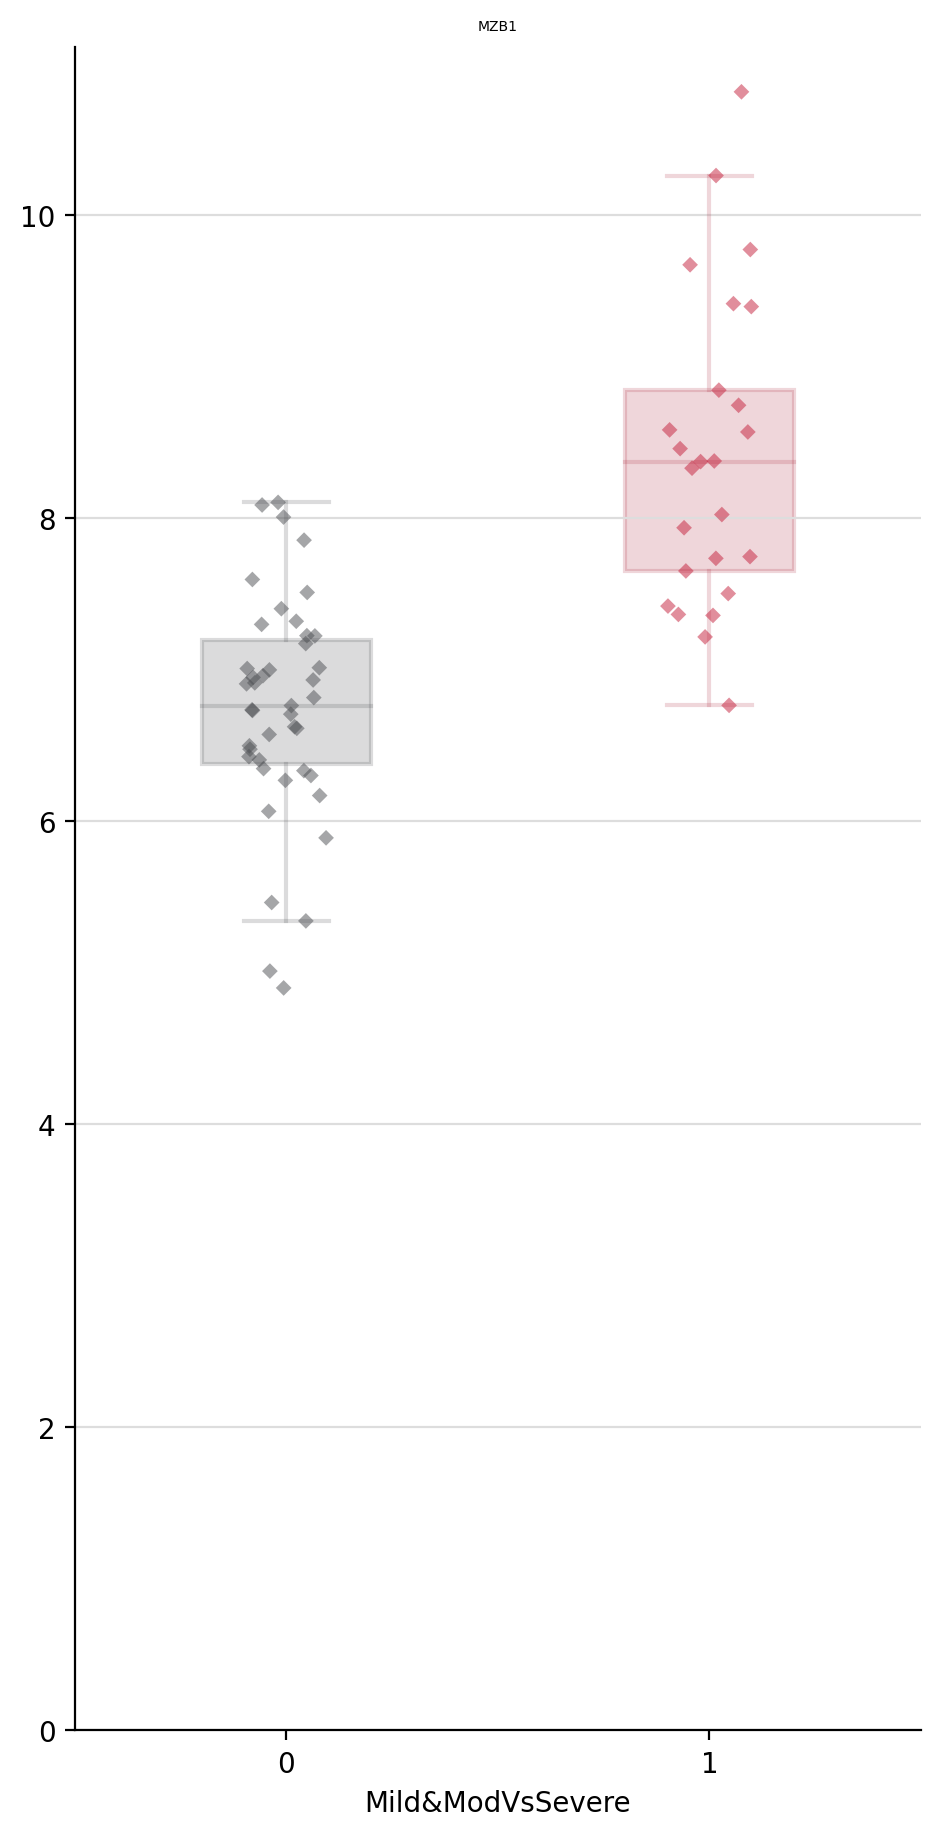

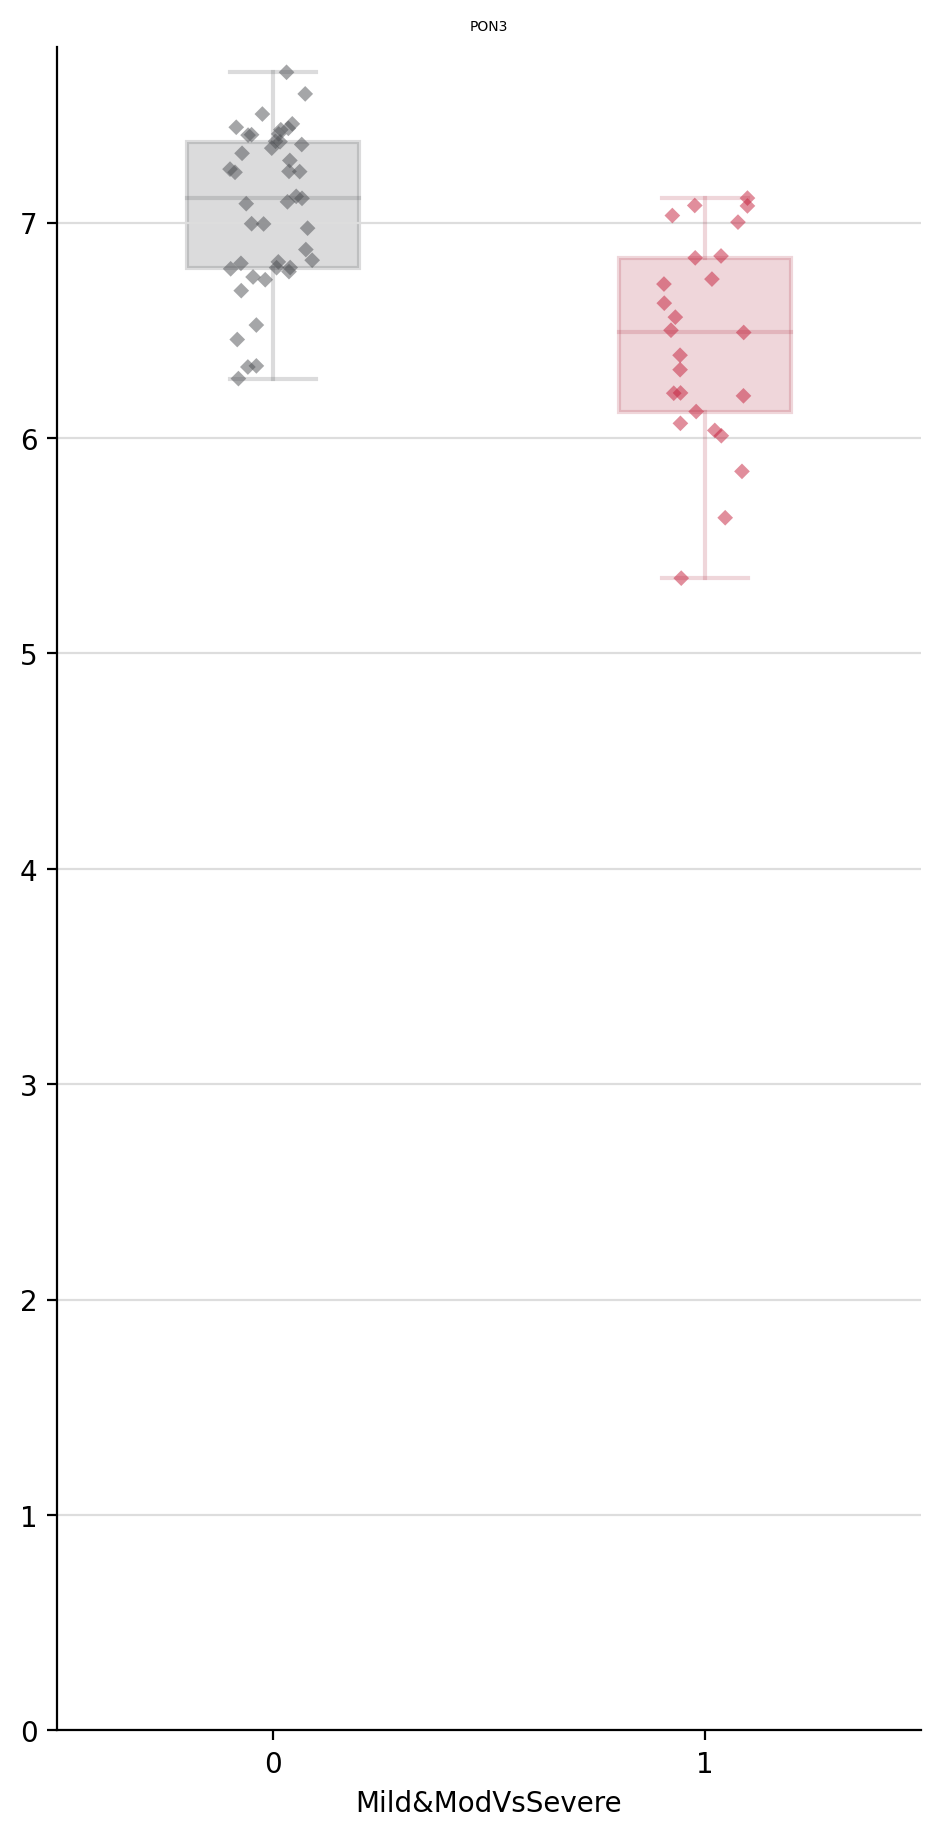

In [31]:
boxplot_features(stabl_class.get_feature_names_out(), prot_covid, covid_pos)

Model
---
(Jonas)

In [32]:
best_scores = dict([(list(prot_covid.columns)[i], (stabl_class.stabl_scores_[i, :]).max()) for i in range(1317)])
C_max = dict([(list(prot_covid.columns)[i], np.argmax(stabl_class.stabl_scores_[i, :])) for i in range(1317)])

resum = pd.DataFrame(columns=['features', 'f_max', 'C_max', 'FDP+ (threshold=0.22)'])
resum['features'] = stabl_class.get_feature_names_out()
resum.set_index = resum['features']

f_max = []
for feature in resum['features']:
    f_max.append(best_scores[feature])

resum['f_max'] = f_max

c_max = []
for feature in resum['features']:
    c_max.append(-C_max[feature])
    
resum['C_max'] = np.linspace(0.01, 1, 30)[c_max]

FDPs = []
artificial_proportion = stabl_class.artificial_proportion
for i in c_max:    
    scores_artificial = stabl_class.stabl_scores_artificial_[:,-i]
    scores = stabl_class.stabl_scores_[:,-i]
    num = np.sum((1 / artificial_proportion) * (scores_artificial > stabl_class.fdr_min_threshold_)) + 1
    denum = max([1, np.sum((scores > stabl_class.fdr_min_threshold_))])
    FDP = num / denum
    FDPs.append(FDP)

resum['FDP+ (threshold=0.22)'] = FDPs

resum = resum.sort_values('FDP+ (threshold=0.22)')


In [33]:
resum

,features,f_max,C_max,FDP+ (threshold=0.22)
0,CCL20,0.317,0.112414,0.166667
1,CRTAC1,0.329,0.044138,0.166667
2,LGALS1,0.243,0.044138,0.166667
3,MDGA1,0.313,0.078276,0.166667
4,MZB1,0.524,0.180690,0.166667
5,PON3,0.242,0.146552,0.166667


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='1 - Specificity', ylabel='Sensitivity'>)

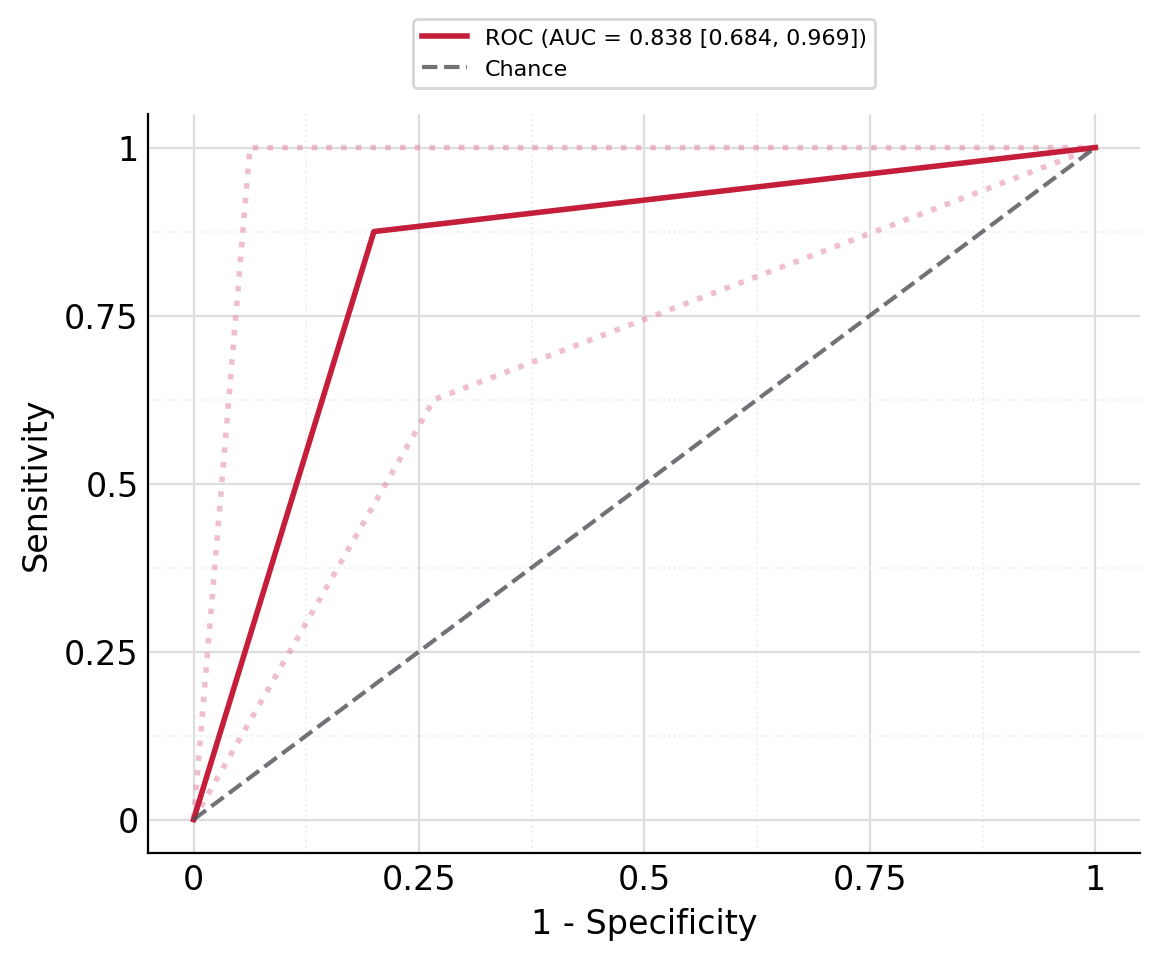

In [34]:
C = resum['C_max'][0]

X = prot_covid[stabl_class.get_feature_names_out()]

X_train, X_test, y_train, y_test = train_test_split(X, covid_pos.loc[common_indices], test_size=0.33, random_state=42)

clf =  LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", C=C)
clf.fit(X_train, y_train)

plot_roc(y_test,clf.predict(X_test))

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Recall', ylabel='Precision'>)

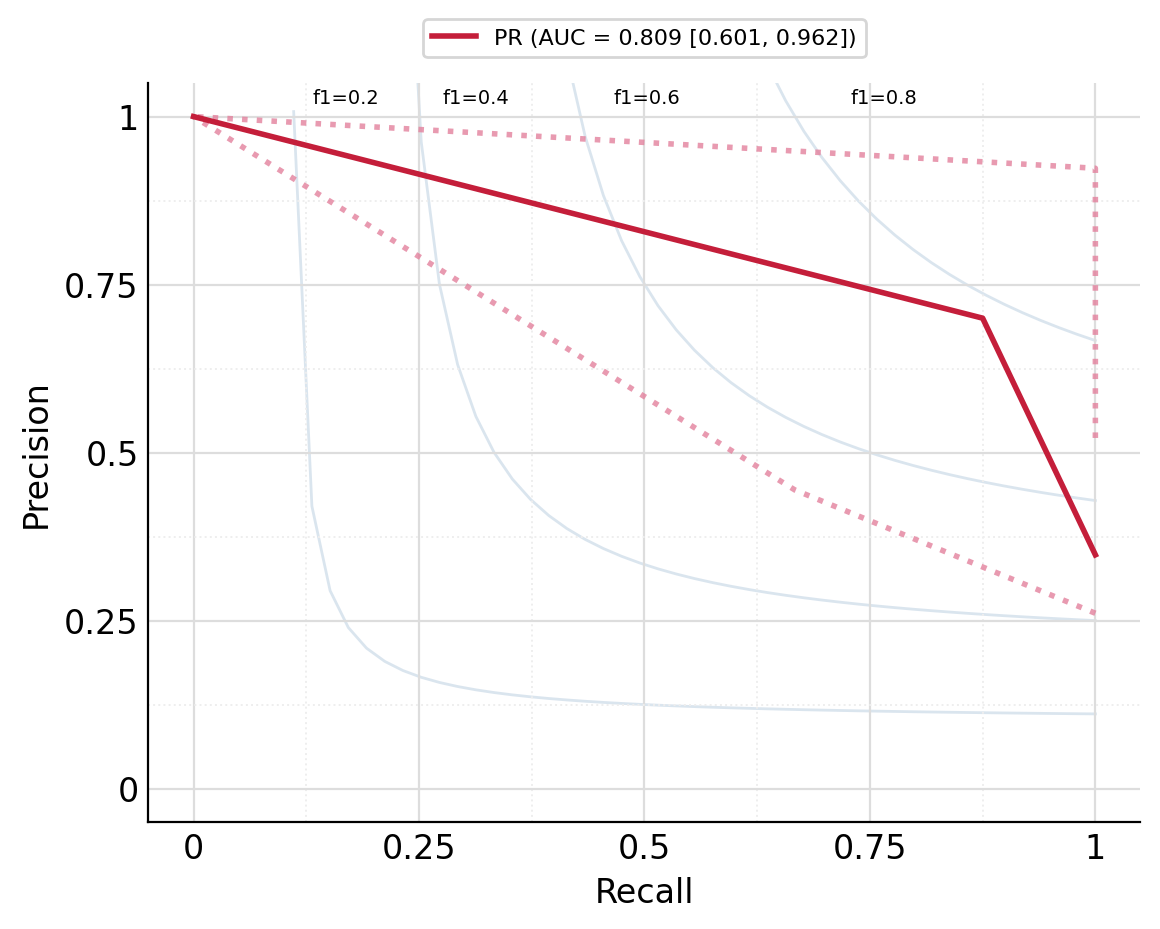

In [35]:
plot_prc(y_test,clf.predict(X_test))

In [36]:
CV_logit_lasso = nonpartition_cross_val_predict(
    LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", C=C),
    prot_covid[stabl_class.get_feature_names_out()],
    covid_pos.loc[common_indices],
    "binary",
    RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=None))

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='1 - Specificity', ylabel='Sensitivity'>)

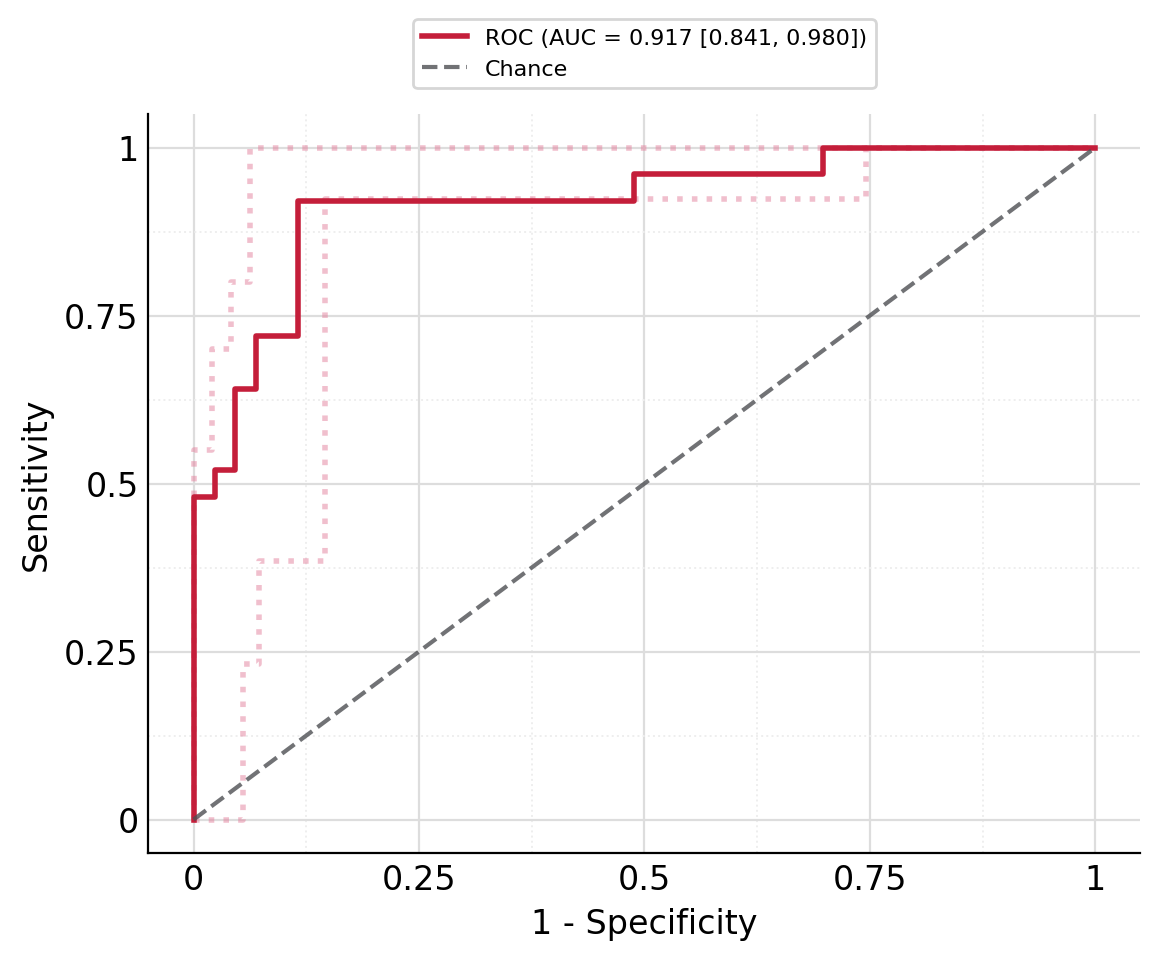

In [37]:
plot_roc(covid_pos.loc[common_indices],CV_logit_lasso[1])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Recall', ylabel='Precision'>)

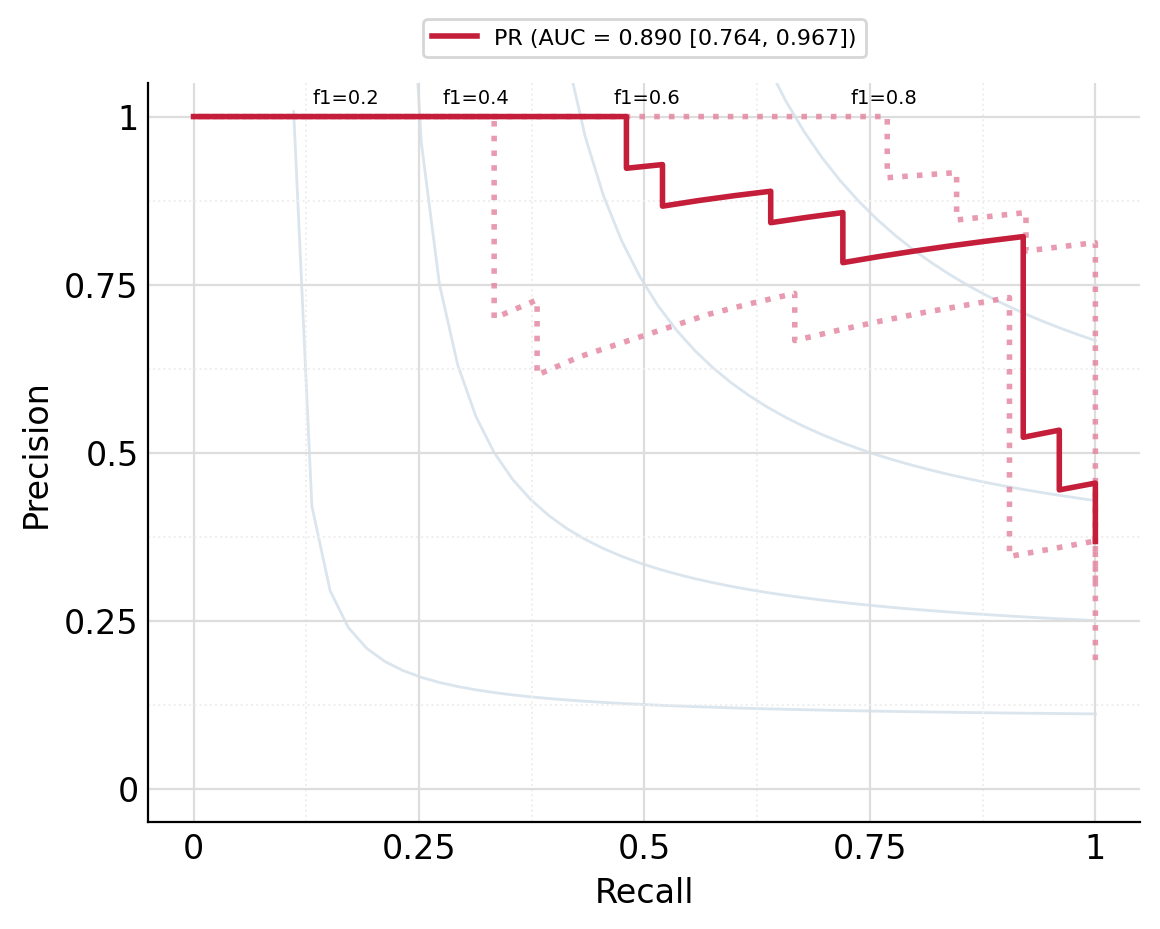

In [38]:
plot_prc(covid_pos.loc[common_indices],CV_logit_lasso[1])